# Performance assessment with SHORT WAVE fluxes in ARPEGE-Climat PPE

<a id="top">This code</a> is assessing model performance based on TOA Short Wave fluxes (SW) within the ARPEGE_Climat Perturbed Physics Ensemble. The metric is then used together with emulators (Multi Linear Regression) to constrain the feedback distribution in the ensemble, but also to study a subset of optimal parameter chosen with the total metric $E_{tot}$ and simulated with ARPEGE-Climat 6.3. <br> 

## It is a 6 steps method : 
### [Step 1 - EOF analysis](#EOF)
### [Step 2 - MultiLinReg predictions](#emulator)
### [Step 3 - Projection of observation dataset](#observation)
### [Step 4 - RMSE estimate](#RMSE)
### [Figure histograms](#histograms)
### [Step 5 - Optimisation](#optim)
### [Step 6 - Optimal subset of parameters](#selection)

# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# Settings

### Variables

In [2]:
variables = ['rsut', 'rsdt']
variable = 'SW'
TITLE = 'Short Wave fluxes'
ylabel = '$E_{SW}$ ($W.m^{-2}.K^{-1}$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_file_npy = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy"
path_file_csv = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv"
path_file_txt = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/txt"

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# <a id="EOF">Step 1 - EOF analysis</a> </li>

For each variable, we consider the climatological mean of the model outputs and we calculate empirical orthogonal functions (EOFs) of the control mean states of the ensemble. In contrast to conventional EOFs, the temporal dimension is replaced by the ensemble itself. This analysis provides a compact description of the spatial and temporal variability of the ensemble variance control climate in term of orthogonal functions, or statistical "modes". The resulting EOFs are spatial patterns, while their principal components ($PCs$) are the expansion coefficients showing the amplitude of the EOF in each ensemble member.

### Functions

In [5]:
def get_3D_SW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    SW = df['rsdt'] - df['rsut']
    
    return SW

In [6]:
def eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure):
    # Plot the EOF map 

    lat = data['lat'][:]
    lon = data['lon'][:]

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()

    eof = eof_nb-1
    data = data[eof]
    ax.set_title(title, fontsize=18, fontweight = 'bold')

    m = Basemap(projection='robin',
            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
    x, y = m(*np.meshgrid(lon,lat))


    cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

    m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
    #m.colorbar()
    cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
    cbar.set_label(' ', size = 16, style = 'italic')

    m.drawcoastlines()
    m.drawmapboundary()
    plt.clim(label_min, label_max)

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

In [7]:
def pc_plot(data, pc_nb, ymin, ymax, title, name_figure):
    #pc = solver.pcs(pcscaling=1)
    #pc = pc*-1

    # Plot the leading PC time series.
    plt.figure(figsize=(10, 5))
    
    pc = pc_nb - 1
    data[:, pc].plot(color='black', linewidth=2)
    ax = plt.gca()
    ax.axhline(0, color='k', alpha=0.5)
    #ax.axvline(x=(8+1), color='red', alpha=0.5)
    #ax.axvline(x=(11+1), color='red', alpha=0.5)
    #ax.axvline(x=(23+1), color='red', alpha=0.5)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Members', size = 16)
    ax.set_ylabel('Normalized Units', size = 16)
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

### Get the data

In [8]:
# Official
path = path_official
filename = '*_CNRM-CM6-1_amip_*.nc'
official_amip = get_3D_SW_xarr(path, filename, variables)

# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_SW_xarr(path, filename, variables)

In [9]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_SW_xarr(path, filename, variables)
    i=i+1  

In [10]:
#amip['official'] = official_amip
amip['p1'] = p1_amip

### Create EOF input matrix

In [11]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

#amip_list[0] = amip['official']
amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    #j=i+1
    amip_list[i+1] = tmp
    i+=1

In [12]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])
matrix

<xarray.DataArray (time: 103, lat: 128, lon: 256)>
dask.array<concatenate, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time

### EOF analysis

In [13]:
# Get weights : 
lats = matrix['lat'].values

wgts = np.cos(np.deg2rad(lats))
W_eof_2D = sqrt(wgts)[:,np.newaxis] ## --Wqts before EOF analysis - 2D (lat x lon)
W_eof_3D = sqrt(wgts)[np.newaxis,:,np.newaxis] ## --Wqts before EOF analysis - 3D (time x lat x lon)

S = wgts.sum()*256 ## --Sum of wgts over the whole grid
wgts_sum = wgts/S
W_rmse_2D = wgts_sum[:,np.newaxis] ## -- Wgts before RMSE, divided by sum of wgts - 2D (lat x lon)

In [14]:
## --Save weights 
np.save(path_file_npy+'/W_eof_2D_'+variable+'.npy', W_eof_2D)
np.save(path_file_npy+'/W_eof_3D_'+variable+'.npy', W_eof_3D)
np.save(path_file_npy+'/W_rmse_2D_'+variable+'.npy', W_rmse_2D)

In [3]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

NameError: name 'matrix' is not defined

In [16]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
anom_df =  anom.to_dataframe(name=str(variables[0])+'mean').drop(labels = 'height', axis=1)

In [17]:
anom_w = (anom*W_eof_3D)
anom_w

<xarray.DataArray (time: 103, lat: 128, lon: 256)>
dask.array<mul, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time

In [18]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom_w, center=False, weights=None)

In [19]:
eof = solver.eofsAsCovariance(neofs=100, pcscaling=1)
pc = solver.pcs(npcs=100, pcscaling=1)

In [20]:
varFrac = solver.varianceFraction(neigs=10)
varFrac

<xarray.DataArray 'variance_fractions' (mode: 10)>
array([0.66048915, 0.11361257, 0.0803175 , 0.02675975, 0.01882436,
       0.01118314, 0.00921894, 0.00759233, 0.00628124, 0.0052729 ])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:  variance_fractions

### EOF 1 : plotting 

In [21]:
varFrac_list = []
for i in varFrac.values :
    tmp = round(i, 2)
    varFrac_list.append(tmp)
varFrac_list

[0.66, 0.11, 0.08, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01]

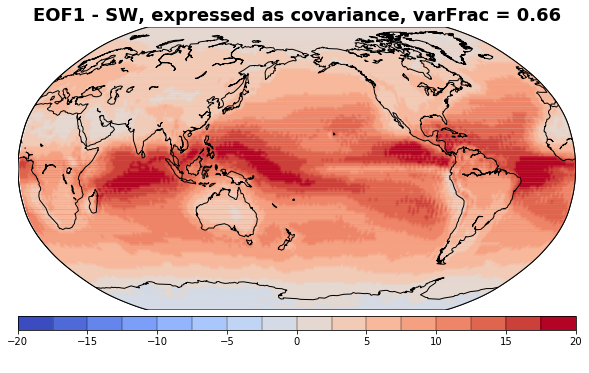

In [22]:
data = eof#*(-1)
eof_nb = 1
title = "EOF1 - "+variable+", expressed as covariance, varFrac = "+str(varFrac_list[0])
label_min = -20
label_max = 20
name_figure = "PPE2_EOF1map_"+str(variable)+".png"
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

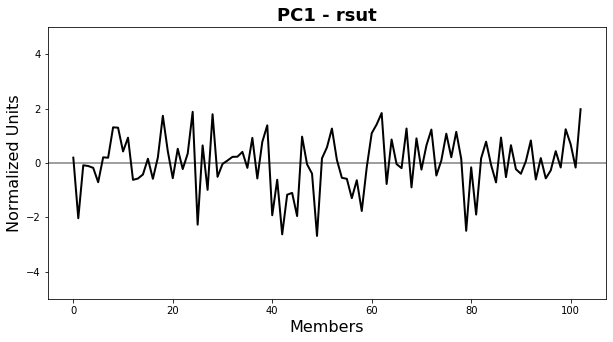

In [23]:
data = pc#*(-1)
pc_nb = 1
ymin = -5
ymax = 5
title = "PC1 - "+str(variables[0])
name_figure = "PPE2_EOF1pc_"+str(variable)+".png"
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 2 : plotting 

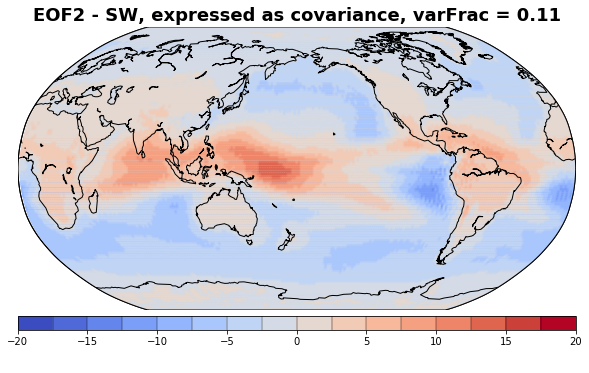

In [24]:
data = eof#*(-1)
eof_nb = 2
title = "EOF2 - "+str(variable)+", expressed as covariance, varFrac = "+str(varFrac_list[1])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF2map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

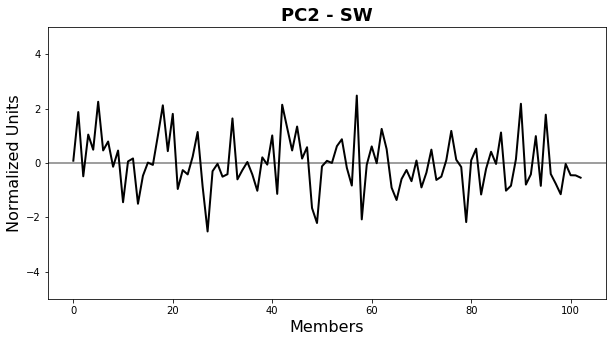

In [25]:
data = pc#*(-1)
pc_nb = 2
ymin = -5
ymax = 5
title = 'PC2 - '+str(variable)
name_figure = 'PPE2_EOF2pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 3 : plotting

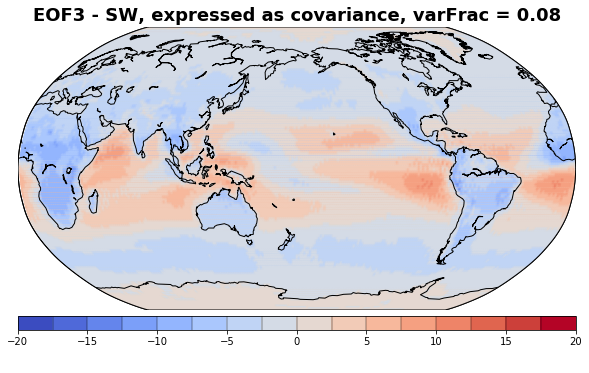

In [26]:
data = eof#*(-1)
eof_nb = 3
title = 'EOF3 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[2])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF3map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

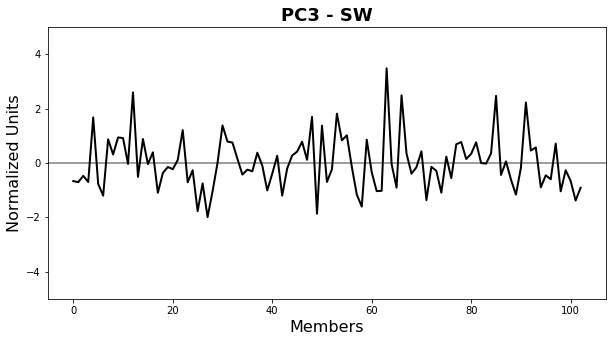

In [27]:
data = pc#*(-1)
pc_nb = 3
ymin = -5
ymax = 5
title = 'PC3 - '+str(variable)
name_figure = 'PPE2_EOF3pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 4 : plotting 

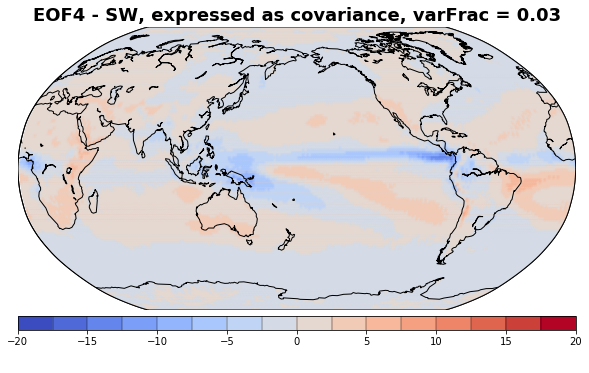

In [28]:
data = eof
eof_nb = 4
title = 'EOF4 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[3])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF4map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

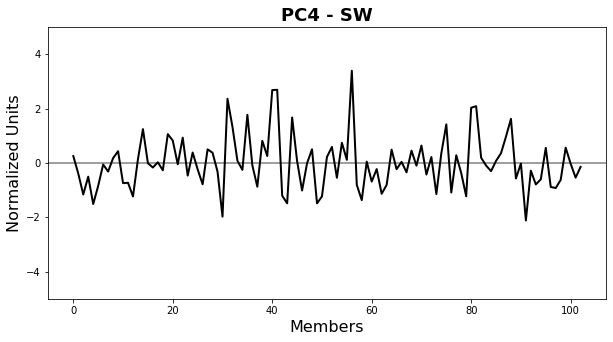

In [29]:
data = pc
pc_nb = 4
ymin = -5
ymax = 5
title = 'PC4 - '+str(variable)
name_figure = 'PPE2_EOF4pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 5 : plotting 

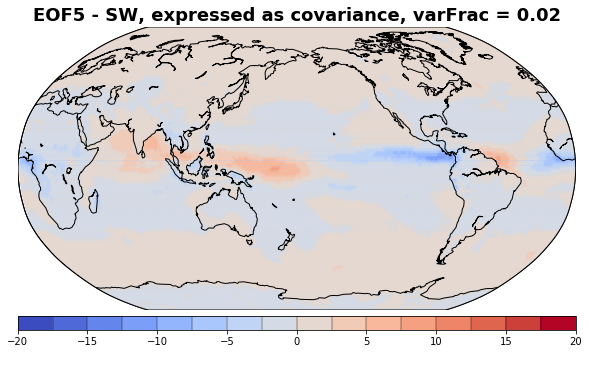

In [30]:
data = eof
eof_nb = 5
title = 'EOF5 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[4])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF5map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

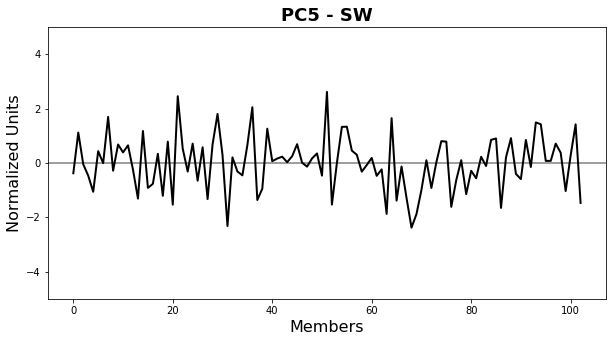

In [31]:
data = pc
pc_nb = 5
ymin = -5
ymax = 5
title = 'PC5 - '+str(variable)
name_figure = 'PPE2_EOF5pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### Save data

#### EOFs

In [32]:
for i in range(0,5,1) :
    j = i+1
    EOF_df = eof[i].to_dataframe().drop(labels = 'mode', axis=1)
    # Save the numpy array in a file  
    EOF_df.to_pickle(path_file_npy+"/PPE2_EOFmap"+str(j)+"_"+str(variable)+".npy")

#### Principal Components

In [33]:
for i in range(0,5,1) :
    j = i+1
    pc_p1 = pc[0,i]
    PC = pc[1:,i]
    
    # Save the numpy array in a file   
    np.save(path_file_npy+'/p1_EOF'+str(j)+'pc_'+str(variable)+'.npy', pc_p1)
    np.save(path_file_npy+'/PPE2_EOF'+str(j)+'pc_'+str(variable)+'.npy', PC)

#### Variance explained, Mean and Anomalies

In [34]:
## --VarFrac 
np.save(path_file_npy+'/PPE2_varFrac_'+str(variable)+'.npy', varFrac)

## --Mean
mean_df.to_pickle(path_file_npy+'/PPE2_'+str(variable)+'_mean.npy')

## --Anom
anom_df.to_pickle(path_file_npy+'/PPE2_'+str(variable)+'_anom.npy')

### [Back to the top](#top)

# <a id="emulator">Step 2 - MultiLinReg predictions</a> </li>

Use of statistical emulators to predict, based on the perturbed parameter values, ARPEGE-Climat's outputs. The emulators must predict both the climate control mean state (here the global mean tas) and the global net feedback (in another code).  


The emulator is a simple multi linear regression model built and trained to predict the five first $PCs$ of the EOF analysis estimated in [Step 1](#EOF). It is expressed as followed : 
\begin{equation}
    Y = \Sigma_{j=1}^K a_jx_j + R 
    \label{eq_emulator}
\end{equation}

with $Y = PC_i$ the PC of one mode of the EOF analysis ($i=5$), $x_j$ the parameter values, $a_j$ the regression coefficients estimated based on the training of the model, $R$ the intercept and $K=30$ the number of perturbed parameter.

### Functions

In [35]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions_emulation
from Fonctions_emulation import Lasso_tunage
from Fonctions_emulation import Lasso_model
from Fonctions_emulation import plot_model_skill
from Fonctions_emulation import plot_model_skill_lines
from Fonctions_emulation import Lasso_pred
from Fonctions_emulation import MultiLinReg_model
from Fonctions_emulation import MultiLinReg_pred

### EOF 1 - prediction

In [36]:
# Set the X and Y : Y = f(X)
X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
y = np.load(file=path_file_npy+"/PPE2_EOF1pc_"+variable+".npy")
param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

In [37]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.0018918938375773588
Coefficients: 
 [-0.35169341 -0.35265022  0.04846061 -0.05791899 -0.00403657  0.17277621
 -0.04505173  0.06793581 -0.19910661  0.21973687 -0.12526622 -0.11881875
  0.12856129  0.00450023  0.29152321  0.08315254  0.06278029 -0.09305529
 -0.02202211  0.0097411   0.01231099  0.06086079  0.02721984 -0.45608583
 -0.01920937  0.0036078   0.03950226 -0.10658601 -0.31973324 -0.0204384 ]
Score: 
 0.7673830622493613


,y_true,y_eq,members,members_0
0,-2.036090,-0.371384,p311,0
1,-0.087155,-0.117106,p312,1
2,-0.114481,-0.228679,p314,2
3,-0.182461,-0.072467,p316,3
4,-0.710522,0.668184,p317,4
...,...,...,...,...
97,-0.168720,0.297934,p465,97
98,1.238500,1.251831,p467,98
99,0.689616,0.575841,p469,99
100,-0.171863,0.522007,p470,100


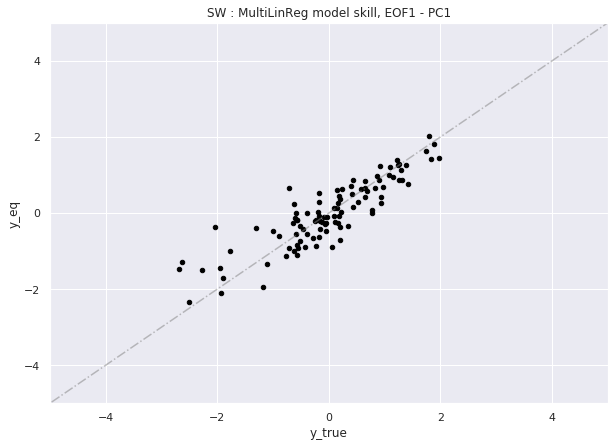

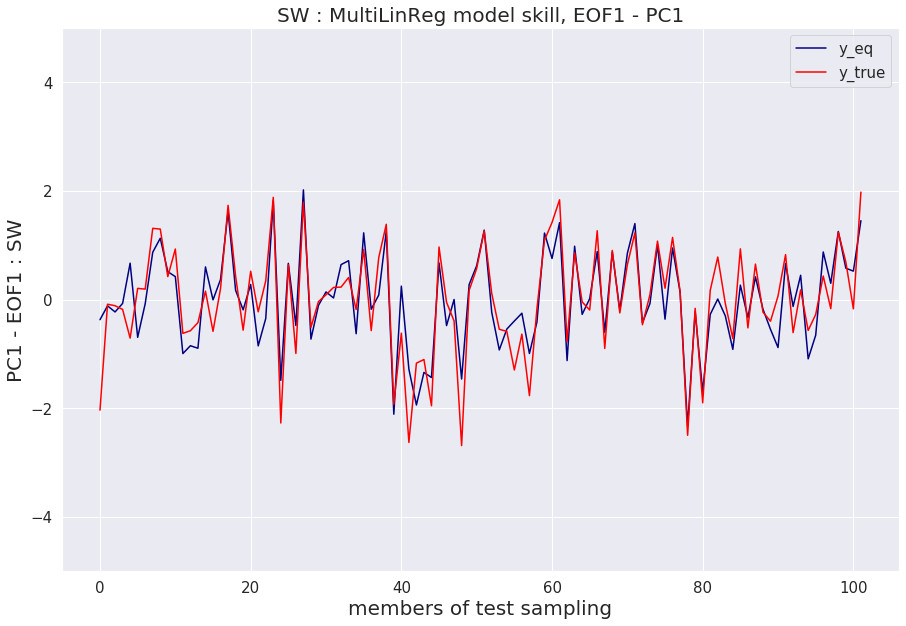

In [39]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF1 - PC1'
xmin = -5
xmax = 5
ymin = -5
ymax = 5
name = 'MultiLinReg_'+variable+'_skill_pc1.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC1 - EOF1 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [41]:
LHS = np.load(file=path_file_npy+"/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.469545,102.0
1,0.288395,103.0
2,-0.596403,104.0
3,0.173458,105.0
4,0.480972,106.0
...,...,...
99995,0.484390,100097.0
99996,-0.497007,100098.0
99997,-0.589315,100099.0
99998,-0.702393,100100.0


#### Save data

In [42]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save(path_file_npy+'/MultiLinReg_validation_eof1_'+variable+'.npy', 
        MultiLinReg_validation)
np.save(path_file_npy+'/MultiLinReg_prediction_eof1_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 2 - prediction

In [43]:
# Set the X and Y : Y = f(X)
X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
y = np.load(file=path_file_npy+"/PPE2_EOF2pc_"+variable+".npy")
param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

In [44]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.0007996878318002269
Coefficients: 
 [ 0.1350729   0.16164058 -0.06471014 -0.05182292  0.16043481 -0.37039874
 -0.1026201   0.1259839   0.02372044  0.20882571  0.03703452  0.1976345
 -0.47481277 -0.06997863  0.22978754  0.07763014 -0.06114966  0.10820223
 -0.07829267  0.09793744 -0.02654758 -0.11484414  0.05448859 -0.12575655
  0.03451299 -0.05450029  0.04019708 -0.03334163 -0.0372723   0.12275655]
Score: 
 0.8185511589904979


,y_true,y_eq,members,members_0
0,1.870624,1.024411,p311,0
1,-0.493208,-0.485534,p312,1
2,1.041783,1.170367,p314,2
3,0.484756,0.788453,p316,3
4,2.249795,1.510361,p317,4
...,...,...,...,...
97,-1.152742,-0.502396,p465,97
98,-0.037122,-0.167176,p467,98
99,-0.453503,-0.778914,p469,99
100,-0.458835,-0.379446,p470,100


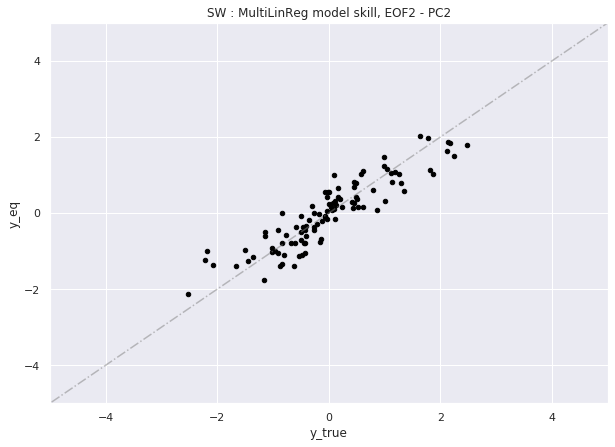

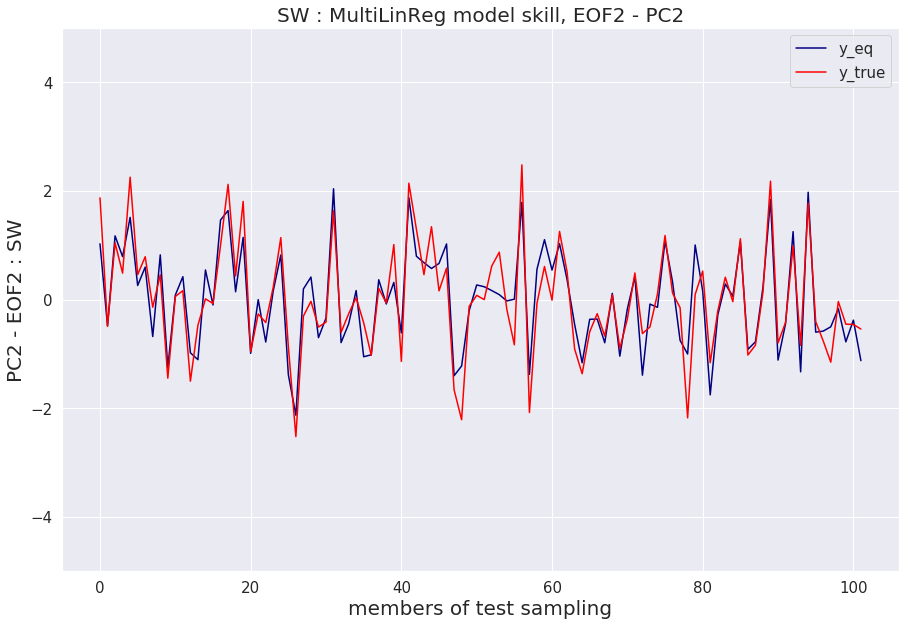

In [45]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF2 - PC2'
xmin = -5
xmax = 5
ymin = -5
ymax = 5
name = 'MultiLinReg_'+variable+'_skill_pc2.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC2 - EOF2 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [46]:
LHS = np.load(file=path_file_npy+"/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.877526,102.0
1,-0.716343,103.0
2,1.055428,104.0
3,-0.155816,105.0
4,0.276575,106.0
...,...,...
99995,-1.665530,100097.0
99996,-0.968395,100098.0
99997,1.286982,100099.0
99998,1.294930,100100.0


#### Save data

In [47]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save(path_file_npy+'/MultiLinReg_validation_eof2_'+variable+'.npy', 
        MultiLinReg_validation)
np.save(path_file_npy+'/MultiLinReg_prediction_eof2_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 3 - prediction

In [48]:
# Set the X and Y : Y = f(X)
X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
y = np.load(file=path_file_npy+"/PPE2_EOF3pc_"+variable+".npy")
param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

In [49]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.006563840332157301
Coefficients: 
 [ 0.15475934  0.27912719  0.49387943 -0.00890224 -0.06717662  0.53175517
 -0.02820959 -0.03699261  0.12730348 -0.11802062 -0.08377095  0.27801386
 -0.21071677 -0.02681758  0.19207863  0.05851362  0.08369845  0.14445602
  0.07801927  0.06648021  0.00065535 -0.07088411  0.00233843 -0.02373287
  0.08091456  0.00540913  0.04661922 -0.01647262  0.25000471  0.13814771]
Score: 
 0.8000364505176717


,y_true,y_eq,members,members_0
0,-0.707113,0.410438,p311,0
1,-0.475993,-0.157410,p312,1
2,-0.702235,-0.809975,p314,2
3,1.673982,1.087064,p316,3
4,-0.770515,-0.573692,p317,4
...,...,...,...,...
97,-1.045304,-0.850715,p465,97
98,-0.270798,-0.085574,p467,98
99,-0.660136,-0.724185,p469,99
100,-1.383297,-1.962446,p470,100


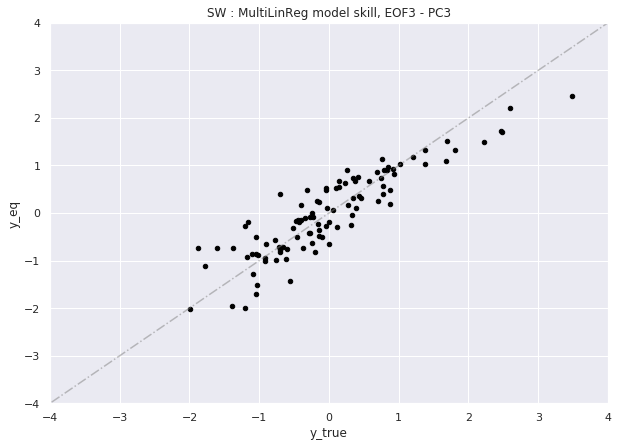

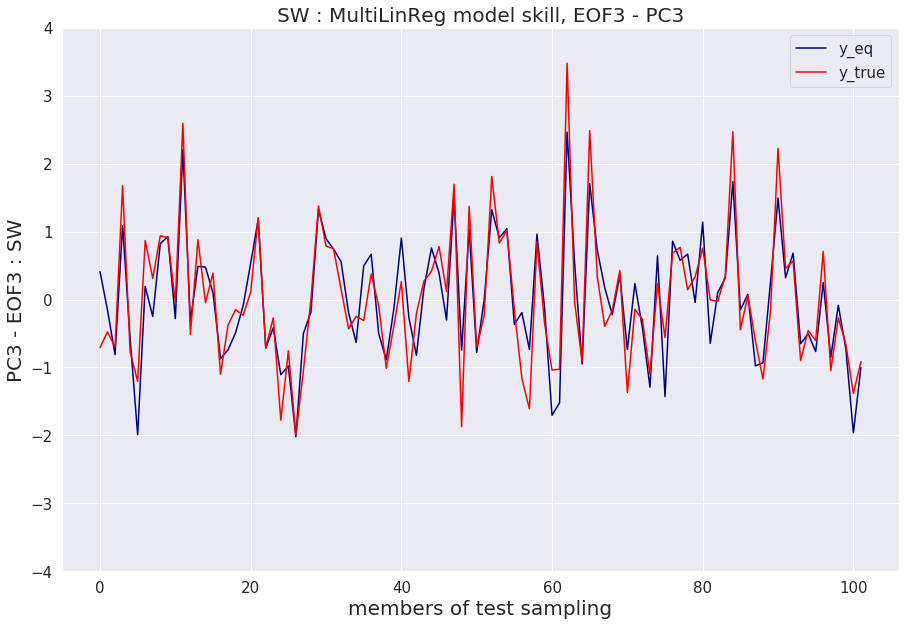

In [50]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF3 - PC3'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc3.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC3 - EOF3 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [51]:
LHS = np.load(file=path_file_npy+"/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,-0.191922,102.0
1,-0.065012,103.0
2,-0.368145,104.0
3,-0.840631,105.0
4,1.317608,106.0
...,...,...
99995,0.497648,100097.0
99996,-0.502236,100098.0
99997,-0.474995,100099.0
99998,-1.998083,100100.0


#### Save data

In [52]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save(path_file_npy+'/MultiLinReg_validation_eof3_'+variable+'.npy', 
        MultiLinReg_validation)
np.save(path_file_npy+'/MultiLinReg_prediction_eof3_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 4 - prediction

In [54]:
# Set the X and Y : Y = f(X)
X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
y = np.load(file=path_file_npy+"/PPE2_EOF4pc_"+variable+".npy")
param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

In [55]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.002453533752703031
Coefficients: 
 [-0.11203361 -0.40753013 -0.1910012   0.06576411 -0.03847528 -0.27121143
 -0.00781823 -0.17825021  0.02615956 -0.60181944  0.10960326  0.21080462
 -0.20823313 -0.11978122  0.19380078  0.06958852  0.01925005 -0.03662701
  0.18968205 -0.0473043   0.06221702  0.07299119 -0.26913464 -0.01224115
  0.03481155  0.08483328 -0.08021996  0.05460806  0.11477442 -0.02609693]
Score: 
 0.7926846858398714


,y_true,y_eq,members,members_0
0,-0.396013,0.215728,p311,0
1,-1.162121,-0.772116,p312,1
2,-0.506069,-0.894919,p314,2
3,-1.513304,-0.976040,p316,3
4,-0.845883,-0.407241,p317,4
...,...,...,...,...
97,-0.624217,-0.662007,p465,97
98,0.559803,-0.176310,p467,98
99,-0.027370,0.283869,p469,99
100,-0.542851,-0.481290,p470,100


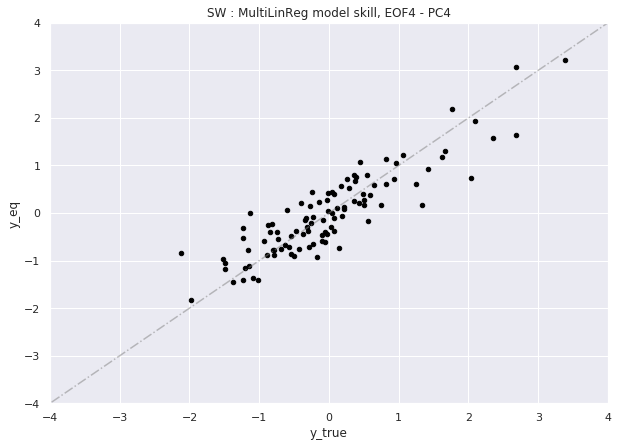

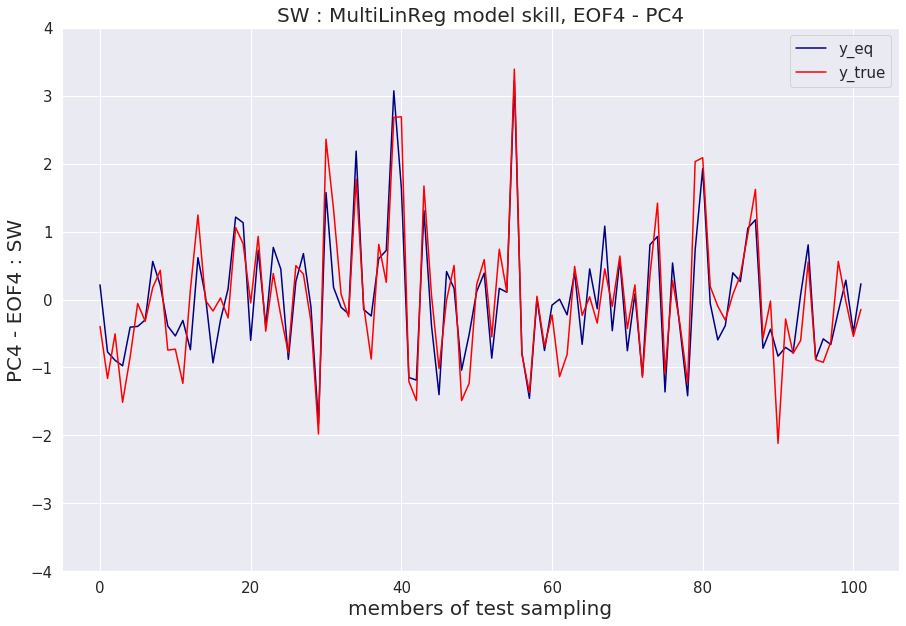

In [56]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF4 - PC4'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc4.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC4 - EOF4 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [57]:
LHS = np.load(file=path_file_npy+"/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.966753,102.0
1,1.781041,103.0
2,-0.793781,104.0
3,0.168080,105.0
4,0.043341,106.0
...,...,...
99995,0.831704,100097.0
99996,0.440812,100098.0
99997,0.072422,100099.0
99998,0.778176,100100.0


#### Save data

In [58]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save(path_file_npy+'/MultiLinReg_validation_eof4_'+variable+'.npy', 
        MultiLinReg_validation)
np.save(path_file_npy+'/MultiLinReg_prediction_eof4_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 5 - prediction

In [59]:
# Set the X and Y : Y = f(X)
X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
y = np.load(file=path_file_npy+"/PPE2_EOF5pc_"+variable+".npy")
param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

In [60]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.003734547909508675
Coefficients: 
 [ 0.00961262  0.00926344  0.02898676 -0.14340817  0.06661142  0.0852558
 -0.04414626 -0.00495836 -0.19206865  0.00831944  0.07132763 -0.25423885
  0.09705914 -0.12207099  0.33958864 -0.05226434 -0.13625324  0.14247017
 -0.05704316  0.19582395 -0.17159562 -0.14186495 -0.03549817  0.42864564
  0.02719432 -0.00922229  0.01483547 -0.13710941 -0.40175324  0.02370101]
Score: 
 0.8628469450236121


,y_true,y_eq,members,members_0
0,1.116171,-0.014231,p311,0
1,-0.052267,0.040817,p312,1
2,-0.471244,-0.352534,p314,2
3,-1.062389,-1.455397,p316,3
4,0.433661,0.009936,p317,4
...,...,...,...,...
97,0.373184,1.282008,p465,97
98,-1.034781,-1.029888,p467,98
99,0.274178,0.258731,p469,99
100,1.417712,1.064809,p470,100


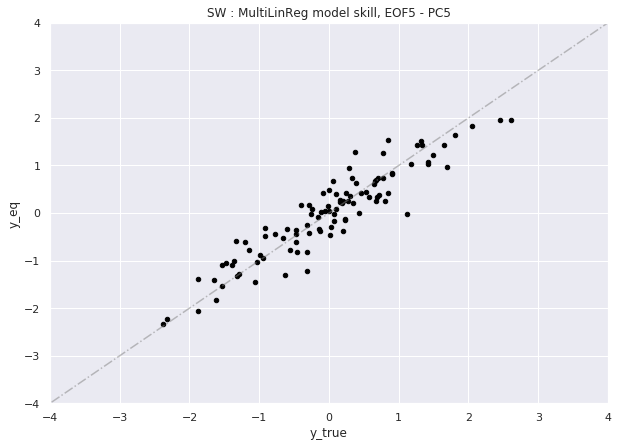

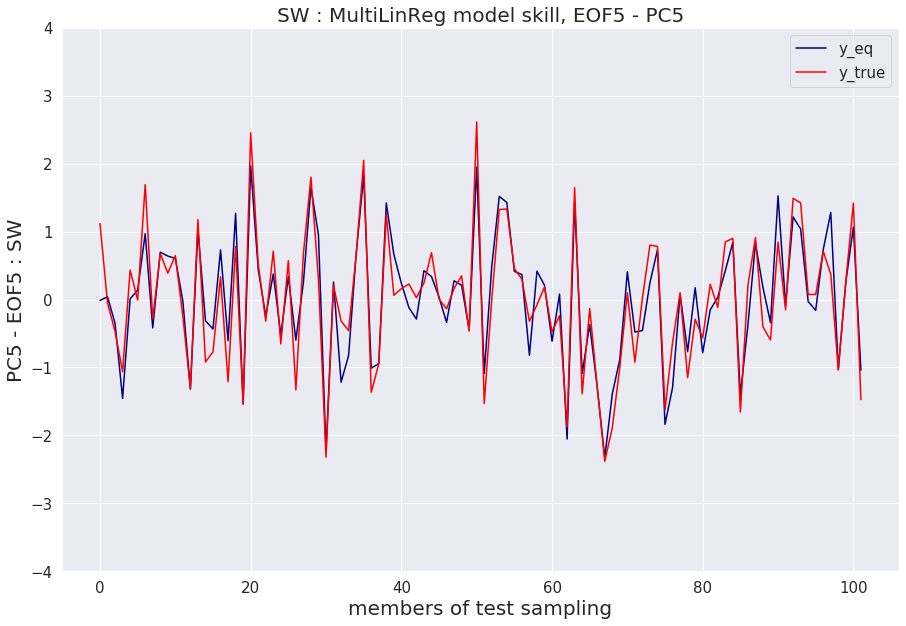

In [61]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF5 - PC5'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc5.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC5 - EOF5 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [62]:
LHS = np.load(file=path_file_npy+"/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,-0.063704,102.0
1,1.450278,103.0
2,-1.606194,104.0
3,1.034677,105.0
4,0.399288,106.0
...,...,...
99995,-1.084613,100097.0
99996,-0.082301,100098.0
99997,-0.269948,100099.0
99998,1.313872,100100.0


#### Save data

In [63]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save(path_file_npy+'/MultiLinReg_validation_eof5_'+variable+'.npy', 
        MultiLinReg_validation)
np.save(path_file_npy+'/MultiLinReg_prediction_eof5_'+variable+'.npy', 
        MultiLinReg_prediction)

### [Back to the top](#top)

# <a id="observation">Step 3 - Projection of observation dataset</a> </li>

In this section, we project the observations ($X_{obs}$) onto the EOFs calculated in [Step 1](#EOF). We call $U_{ens}$ the ensemble matrix of EOF amplitudes $w$ such as :  

$U_{ens} = \begin{pmatrix} 
                w_{1,1} & w_{2,1} & w_{3,1} & w_{4,1} & w_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                w_{1,102} & w_{2,102} & w_{3,102} & w_{4,102} & w_{5,102}
           \end{pmatrix}$ 
           
           
<br>
<br>
<br>
The ensemble matrix of spatial patterns is called $v_{ens}$ and is expresses such as : 

$v_{ens} = \begin{pmatrix} 
                eof1(lat,lon)  \\ 
                eof2(lat,lon)  \\ 
                eof3(lat,lon)  \\ 
                eof4(lat,lon)  \\ 
                eof5(lat,lon)  \\ 
           \end{pmatrix}$ 


<br>

The EOF analysis can be expresses as : 
$X_{ens} = U_{ens} \cdot v_{ens}$

And we want the EOF amplitudes of the observations within this basis such as : 

$X_{obs} = U_{obs} \cdot v_{ens}$ 

$U_{obs} = X_{obs} \cdot {v_{ens}}^{-1}$

With : 

$U_{obs} = \begin{pmatrix} 
                o_{1,1} & o_{2,1} & o_{3,1} & o_{4,1} & o_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                o_{1,102} & o_{2,102} & o_{3,102} & o_{4,102} & o_{5,102}
           \end{pmatrix}$ 

### Settings

In [64]:
path_observation = '/data/scratch/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'

### Functions

In [97]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

### Get the data 

In [66]:
Mean =  pd.read_pickle(path_file_npy+'/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
Mean

<xarray.DataArray (lat: 128, lon: 256)>
array([[46.2103  , 46.2103  , 46.2103  , ..., 46.2103  , 46.2103  ,
        46.2103  ],
       [52.110836, 52.110836, 52.110836, ..., 52.110836, 52.110836,
        52.110836],
       [49.190533, 49.190533, 49.190533, ..., 49.07198 , 49.190533,
        49.190533],
       ...,
       [57.36108 , 57.36108 , 57.36108 , ..., 57.962273, 57.36108 ,
        57.36108 ],
       [56.612976, 56.612976, 56.612976, ..., 56.612976, 56.612976,
        56.612976],
       [55.84883 , 55.84883 , 55.84883 , ..., 55.84883 , 55.84883 ,
        55.84883 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'SWmean'

In [67]:
pc1 = np.load(path_file_npy+'/PPE2_EOF1pc_'+variable+'.npy')
pc2 = np.load(path_file_npy+'/PPE2_EOF2pc_'+variable+'.npy')
pc3 = np.load(path_file_npy+'/PPE2_EOF3pc_'+variable+'.npy')
pc4 = np.load(path_file_npy+'/PPE2_EOF4pc_'+variable+'.npy')
pc5 = np.load(path_file_npy+'/PPE2_EOF5pc_'+variable+'.npy')

PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1
PC_df['pc2'] = pc2
PC_df['pc3'] = pc3
PC_df['pc4'] = pc4
PC_df['pc5'] = pc5
PC_df = PC_df.drop(labels = 0, axis=1)

#PC_df

In [68]:
# Load data and compute Annual Cycle :
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon
month lat        lon                                                       
1     -88.927735 0.00000        344.953522      189.246185       -38.599289
                 1.40625        344.953522      189.246185       -38.599289
                 2.81250        344.953522      189.246185       -38.599289
                 4.21875        344.992493      189.144440       -38.531315
                 5.62500        345.007721      189.104630       -38.504715
...                                    ...             ...              ...
12     88.927735 352.96875        0.000000      171.476639      -171.476639
                 354.37500        0.000000      171.476639      -171.476639
                 355.78125        0.000000      171.500351      -171.500351
                 357.18750        0.000000      171.560974      -171.560974
                 358.59375        0.000000      171.560974      -171.560974

[393216 rows x 3 columns]

In [69]:
df_obs['SW'] =  df_obs['toa_net_all_mon'] + df_obs['toa_lw_all_mon']
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    SW               (lat, lon) float32 51.417324 51.417324 ... 67.64632

In [70]:
X_obs = obs[variable] - Mean
X_obs_bis = X_obs*W_eof_2D
U_obs_avg = solver.projectField(X_obs_bis, neofs=5, weighted=False, eofscaling=1)#[0,:]
U_obs_avg

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([ 0.65468585,  1.6135917 , -0.71291387,  0.99325839, -0.88357248])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  None_pseudo_pcs

### Save data

In [71]:
#Save the U_obs_avg 
np.save(path_file_npy+'/U_obs_'+variable+'.npy', U_obs_avg)

# Projection of CFMIP data

In [72]:
variables = ['rsdt', 'rsut']

In [73]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    f=file[variables]
    SW = f['rsdt'] - f['rsut']
    df = SW.to_dataframe(name='SW')
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month

    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

In [74]:
# Download the amip dataframes and compute the radiative budget  

path = "/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/"
filename = "*_amip_*.nc"
CNRM_amip = load_monthly_clim(path, filename, variables)

path = "/data/scratch/globc/peatier/CMIP6/MRI-ESM2-0/amip/"
filename = "*_amip_*regrid.nc"
MRI_amip = load_monthly_clim(path, filename, variables)

path = "/data/scratch/globc/peatier/CMIP6/CanESM5/amip/"
filename = "standard_*_amip_*regrid.nc"
CAN_amip = load_monthly_clim(path, filename, variables)
CAN_amip

path = "/data/scratch/globc/peatier/CMIP6/MIROC6/"
filename = "*_amip_*regrid.nc"
MIROC_amip = load_monthly_clim(path, filename, variables)
MIROC_amip

path = "/data/scratch/globc/peatier/CMIP6/HadGEM3-GC31-LL/"
filename = "standard_*_amip_*regrid.nc"
HadGEM3_amip = load_monthly_clim(path, filename, variables)
HadGEM3_amip

path = "/data/scratch/globc/peatier/CMIP6/IPSL-CM6A-LR/"
filename = "*_amip_*regrid.nc"
IPSL_amip = load_monthly_clim(path, filename, variables)
IPSL_amip

path = "/data/scratch/globc/peatier/CMIP6/BCC-CSM2-MR/"
filename = "standard_*_amip_*regrid.nc"
BCC_amip = load_monthly_clim(path, filename, variables)
BCC_amip

height          SW
month lat        lon                          
1     -88.927735 0.00000       2.0  145.884003
                 1.40625       2.0  145.873138
                 2.81250       2.0  145.870056
                 4.21875       2.0  145.856934
                 5.62500       2.0  145.843735
...                            ...         ...
12     88.927735 352.96875     2.0    0.000000
                 354.37500     2.0    0.000000
                 355.78125     2.0    0.000000
                 357.18750     2.0    0.000000
                 358.59375     2.0    0.000000

[393216 rows x 2 columns]

In [75]:
variables = ['SW']

df_obs = pd.DataFrame()
df_obs['CNRM'] = CNRM_amip[variables[0]]
df_obs['MRI'] = MRI_amip[variables[0]]
df_obs['CAN'] = CAN_amip[variables[0]]
df_obs['MIROC'] = MIROC_amip[variables[0]]
df_obs['HadGEM3'] = HadGEM3_amip[variables[0]]
df_obs['IPSL'] = IPSL_amip[variables[0]]
df_obs['BCC'] = BCC_amip[variables[0]]
#df_obs = df_obs.drop(['rsut', 'height'], axis = 1)
df_obs

CNRM         MRI         CAN       MIROC  \
month lat        lon                                                       
1     -88.927735 0.00000    131.5383  146.031296  161.333176  177.961044   
                 1.40625    131.5383  145.848328  161.332718  177.934998   
                 2.81250    131.5383  145.700485  161.186417  177.912430   
                 4.21875    131.5383  145.554535  161.186035  177.888153   
                 5.62500    131.5383  145.642990  161.185654  177.797394   
...                              ...         ...         ...         ...   
12     88.927735 352.96875    0.0000    0.000000    0.000000    0.000000   
                 354.37500    0.0000    0.000000    0.000000    0.000000   
                 355.78125    0.0000    0.000000    0.000000    0.000000   
                 357.18750    0.0000    0.000000    0.000000    0.000000   
                 358.59375    0.0000    0.000000    0.000000    0.000000   

                               HadGEM3        IPSL         BCC  
month lat        lon                                            
1     -88.927735 0.00000    154.982834  146.193268  145.884003  
                 1.40625    154.983063  146.186111  145.873138  
                 2.81250    154.994812  146.177307  145.870056  
                 4.21875    154.988861  146.162781  145.856934  
                 5.62500    154.987213  146.145279  145.843735  
...                                ...         ...         ...  
12     88.927735 352.96875    0.000000    0.000000    0.000000  
                 354.37500    0.000000    0.000000    0.000000  
                 355.78125    0.000000    0.000000    0.000000  
                 357.18750    0.000000    0.000000    0.000000  
                 358.59375    0.000000    0.000000    0.000000  

[393216 rows x 7 columns]

In [76]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    CNRM     (lat, lon) float32 45.05837 45.05837 45.05837 ... 57.14525 57.14525
    MRI      (lat, lon) float32 47.382782 47.34307 ... 57.380543 57.3424
    CAN      (lat, lon) float32 54.20409 54.203995 ... 64.81918 64.81959
    MIROC    (lat, lon) float32 57.22528 57.216164 ... 59.829773 59.819878
    HadGEM3  (lat, lon) float32 51.2327 51.22905 ... 63.225594 63.235786
    IPSL     (lat, lon) float32 50.42652 50.4243 ... 69.805374 69.78369
    BCC      (lat, lon) float32 49.072968 49.06905 ... 57.981056 57.984173

## Compute Anomaly

In [77]:
X_obs = {}
X_obs['CNRM'] = obs['CNRM'] - Mean
X_obs['MRI'] = obs['MRI'] - Mean
X_obs['CAN'] = obs['CAN'] - Mean
X_obs['MIROC'] = obs['MIROC'] - Mean
X_obs['HadGEM3'] = obs['HadGEM3'] - Mean
X_obs['IPSL'] = obs['IPSL'] - Mean
X_obs['BCC'] = obs['BCC'] - Mean
#X_obs

In [78]:
X_obs['CNRM'] = (X_obs['CNRM']*W_eof_2D)
U_CNRM_avg = solver.projectField(X_obs['CNRM'], neofs=5, weighted=False, eofscaling=1)

X_obs['MRI'] = (X_obs['MRI']*W_eof_2D)
U_MRI_avg = solver.projectField(X_obs['MRI'], neofs=5, weighted=False, eofscaling=1)

X_obs['CAN'] = (X_obs['CAN']*W_eof_2D)
U_CAN_avg = solver.projectField(X_obs['CAN'], neofs=5, weighted=False, eofscaling=1)

X_obs['MIROC'] = (X_obs['MIROC']*W_eof_2D)
U_MIROC_avg = solver.projectField(X_obs['MIROC'], neofs=5, weighted=False, eofscaling=1)

X_obs['HadGEM3'] = (X_obs['HadGEM3']*W_eof_2D)
U_HadGEM3_avg = solver.projectField(X_obs['HadGEM3'], neofs=5, weighted=False, eofscaling=1)

X_obs['IPSL'] = (X_obs['IPSL']*W_eof_2D)
U_IPSL_avg = solver.projectField(X_obs['IPSL'], neofs=5, weighted=False, eofscaling=1)

X_obs['BCC'] = (X_obs['BCC']*W_eof_2D)
U_BCC_avg = solver.projectField(X_obs['BCC'], neofs=5, weighted=False, eofscaling=1)

In [79]:
#Save the U_obs_avg 
np.save(path_file_npy+'/U_CNRM_'+variable+'.npy', U_CNRM_avg)
np.save(path_file_npy+'/U_MRI_'+variable+'.npy', U_MRI_avg)
np.save(path_file_npy+'/U_CAN_'+variable+'.npy', U_CAN_avg)
np.save(path_file_npy+'/U_MIROC_'+variable+'.npy', U_MIROC_avg)
np.save(path_file_npy+'/U_HadGEM3_'+variable+'.npy', U_HadGEM3_avg)
np.save(path_file_npy+'/U_IPSL_'+variable+'.npy', U_IPSL_avg)
np.save(path_file_npy+'/U_BCC_'+variable+'.npy', U_BCC_avg)

### [Back to the top](#top)

# <a id="RMSE">Step 4 - RMSE estimate</a> </li>

The model error as compared to observations is calculated by comparing the EOF amplitudes $w$ in each member with the projection of the observations $o$ on the model EOF basis through a Root Mean Square Error (RMSE). For a given member of the PPE, the error associated with the variable $s$ is : 

\begin{equation}
    E_{s} = \sqrt{\Sigma_i^N \frac{(w_{is}-o_{is})^2}{N}}
\end{equation}

with $i$ varying from $1$ to $N$, the number of modes considered. In the present study, we truncated the EOF after the 5th mode for each variable : $N=5$.

### Settings

In [80]:
product = 'CERES'
N_error=128*256

### Functions

In [81]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [82]:
def RMSE(mod, obs) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

In [83]:
def RMSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = RMSE(mod, obs)
    return diff

### Get the data 

In [84]:
Mean =  pd.read_pickle(path_file_npy+'/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})

In [85]:
eofs=[]
for i in range(1,6,1) :
    eof_tmp = pd.read_pickle(path_file_npy+'/PPE2_EOFmap'+str(i)+'_'+variable+'.npy').to_xarray().to_array()
    eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
    eofs.append(eof_tmp)
                     
## --Combine the 5 modes for reconstruction
eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')

In [86]:
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
pc = U_obs
nb_dims = 2 
X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

### p1 default model

In [87]:
pc_p1=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/p1_EOF'+str(i)+'pc_'+variable+'.npy')
    pc_p1.append(pc_tmp)

p1_feedbacks = np.load(path_file_npy+'/Net_feedbacks_p1.npy')

In [88]:
pc = pc_p1
nb_dims = 2
X_rec_p1 = reconstruct_X(eofs_combined, pc, nb_dims)
X_rec_p1

<xarray.DataArray (lat: 128, lon: 256)>
array([[-0.03787364, -0.03787364, -0.03787364, ..., -0.03787364,
        -0.03787364, -0.03787364],
       [-0.02246766, -0.02246766, -0.02246766, ..., -0.02246766,
        -0.02246766, -0.02246766],
       [-0.02138248, -0.02138248, -0.02138248, ..., -0.01866763,
        -0.02138248, -0.02138248],
       ...,
       [-0.01169192, -0.01169192, -0.01169192, ..., -0.01646158,
        -0.01169192, -0.01169192],
       [-0.0174126 , -0.0174126 , -0.0174126 , ..., -0.0174126 ,
        -0.0174126 , -0.0174126 ],
       [-0.01122753, -0.01122753, -0.01122753, ..., -0.01122753,
        -0.01122753, -0.01122753]])
Coordinates:
    mode     <U4 'eofs'
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

In [89]:
E_p1 = RMSE_rec(X_rec_p1, X_rec_obs, Mean)
E_p1

<xarray.DataArray ()>
array(8.18129142)

In [98]:
path_observation = '/data/scratch/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'
variable_obs = 'SW'

path = path_observation
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path, filename, variables)
df_obs[variable_obs] =  df_obs['toa_net_all_mon'] + df_obs['toa_lw_all_mon']

obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    SW               (lat, lon) float32 51.417324 51.417324 ... 67.64632

In [99]:
mod = amip_list[0]
observation = obs[variable]
RMSE_p1 = RMSE(mod, observation).values
RMSE_p1

array(13.46957819)

### CMIP6 models

In [100]:
nb_dims = 2

## Reconstruct and compute RMSE_rec 

filename = 'U_MRI_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_MRI = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_CAN_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_CAN = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_MIROC_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_MIROC = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_HadGEM3_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_HadGEM3 = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_IPSL_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_IPSL = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

filename = 'U_BCC_'+variable+'.npy'
pc = np.load(path_file_npy+'/'+filename)
X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
E_BCC = RMSE_rec(X_rec_mod, X_rec_obs, Mean)

### PPE

In [101]:
pc_PPE=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/PPE2_EOF'+str(i)+'pc_'+str(variable)+'.npy')
    pc_PPE.append(pc_tmp)

In [102]:
X_PPE = []
for i in range(0,102,1) :
    pc = [pc_PPE[0][i], pc_PPE[1][i], pc_PPE[2][i], pc_PPE[3][i], pc_PPE[4][i]]
    nb_dims = 2
    X_PPE_tmp = reconstruct_X(eofs_combined, pc, nb_dims)
    
    X_PPE.append(X_PPE_tmp)

In [103]:
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
pc = U_obs
nb_dims = 2 
X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

In [104]:
E_PPE = []
RMSE_PPE = []
observation = obs[variable]
mod_list = amip_list[1:]  ## --Because amip_list[0] is p1

for i in range(0,len(X_PPE),1) :
    E_PPE_tmp = RMSE_rec(X_PPE[i], X_rec_obs, Mean)
    RMSE_PPE_tmp = RMSE(mod_list[i], observation)
    
    E_PPE.append(float(E_PPE_tmp))
    RMSE_PPE.append(float(RMSE_PPE_tmp))

## Check the correlation with simple RMSE

In [105]:
df_fig = pd.DataFrame(E_PPE, columns=['E_PPE'])
df_fig['RMSE_PPE'] = RMSE_PPE
df_fig

,E_PPE,RMSE_PPE
0,27.756642,30.505201
1,12.577989,17.133245
2,8.773974,15.118996
3,13.905584,17.927789
4,14.813880,19.916895
...,...,...
97,14.947696,18.788210
98,9.332918,14.375918
99,9.195344,14.644479
100,13.354620,17.908857


In [106]:
r = np.corrcoef(df_fig['E_PPE'], df_fig['RMSE_PPE'])
r = r[0,1].round(2)
r

0.99

In [107]:
E = df_fig['E_PPE']
R = df_fig['RMSE_PPE']
coeff1 = (E[90] - E[85])/(R[90] - R[85])
coeff2 = (E[50] - E[45])/(R[50] - R[45])
coeff3 = (E[100] - E[95])/(R[100] - R[95])
coeff4 = (E[80] - E[75])/(R[80] - R[75])
coeff5 = (E[60] - E[55])/(R[60] - R[55])
coeff6 = (E[101] - E[96])/(R[101] - R[96])
coeff = (coeff1 + coeff2 + coeff3 + coeff4 + coeff5)/5
line_tmp = R*coeff
intercept = E.mean() - line_tmp.mean()
line = np.arange(0.2,2.6,0.02)*coeff 
line = line + intercept

In [108]:
df_line = pd.DataFrame(line, columns=['line'])
df_line['x'] = np.arange(0.2,2.6,0.02)
df_line

,line,x
0,-5.522944,0.20
1,-5.501527,0.22
2,-5.480110,0.24
3,-5.458693,0.26
4,-5.437276,0.28
...,...,...
115,-3.059998,2.50
116,-3.038581,2.52
117,-3.017164,2.54
118,-2.995748,2.56


/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <matplotlib.lines.Line2D object at 0x2abf9048d250> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


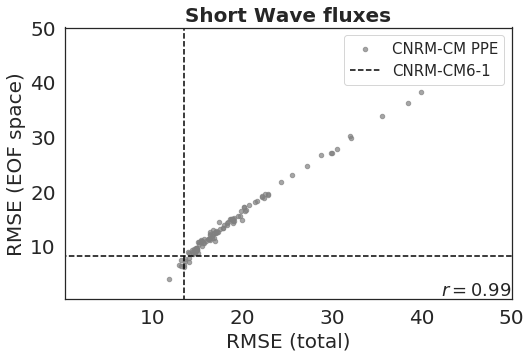

In [112]:
plt.figure(figsize=(8, 5))
    
ax = plt.gca()

df_fig.plot(kind='scatter', y='E_PPE', x='RMSE_PPE', color = 'gray', alpha=0.7, ax=ax)
df_line.plot(kind='line', y='line', x='x', color = 'gray', alpha=0.3, linestyle="-.", 
             label = '_nolegend_', ax=ax)

plt.hlines(E_p1,xmin = -2.0,xmax = 50,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(RMSE_p1,ymin = 0,ymax = 50,label='default simulation', colors='black', 
           linestyles='dashed')

ax.set_xlabel('RMSE (total)', size = 20)
ax.set_ylabel('RMSE (EOF space)', size = 20)
ax.set_title('Short Wave fluxes', fontsize=20, 
             fontweight = 'bold')

plt.text(1,0.0,r'$r = $'+str(r),horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.plot((0.3, 1.75), (1, 2), linewidth=1.0, color='gray', alpha=0.2)

plt.xlim([0.3, 50])
plt.ylim([0.3, 50])

# Legend .................

legend = ['CNRM-CM PPE', 'CNRM-CM6-1']
ax.get_legend().remove()
ax.legend(legend, fontsize=15) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
sns.set_style(style='white') 
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Correl_RMSE_E_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Multi-Linear Regression predictions

In [113]:
pc_pred=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/MultiLinReg_prediction_eof'+str(i)+'_'+variable+'.npy')
    pc_pred.append(pc_tmp)

In [114]:
pc_val=[]
for i in range(1,6,1) :
    pc_tmp = np.load(path_file_npy+'/MultiLinReg_validation_eof'+str(i)+'_'+variable+'.npy')
    pc_val.append(pc_tmp)

In [115]:
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
pc = U_obs
nb_dims = 2 
X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

In [116]:
E_pred = []
nb_dims = 2

## --E_tas of MultiLinReg predictions :
for i in range(0,len(pc_pred[0]),1) : ## --100 000 for a 100 000 LHS predictions 
    
    pc = [pc_pred[0][i], pc_pred[1][i], pc_pred[2][i], pc_pred[3][i], pc_pred[4][i]]
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
    E_tmp = RMSE_rec(X_rec_mod, X_rec_obs, Mean)
    E_pred.append(float(E_tmp))

In [117]:
E_val = []
nb_dims = 2

## --E_tas of MultiLinReg predictions :
for i in range(0,len(pc_val[0]),1) : ## --100 000 for a 100 000 LHS predictions 
    
    pc = [pc_val[0][i], pc_val[1][i], pc_val[2][i], pc_val[3][i], pc_val[4][i]]
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims)
    E_tmp = RMSE_rec(X_rec_mod, X_rec_obs, Mean)
    E_val.append(float(E_tmp))

### Get the feedbacks

In [118]:
Fdbck_PPE = np.load(file=path_file_npy+"/Net_feedbacks.npy")
Fdbck_multilinreg_val = np.load(file=path_file_npy+"/MultiLinReg_validation_FdbckN.npy")
Fdbck_multilinreg_pred = np.load(file=path_file_npy+"/MultiLinReg_prediction_FdbckN.npy")

Fdbck_CFMIP = np.load(file=path_file_npy+'/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

In [119]:
E_PPE_df = pd.DataFrame(E_PPE, columns=['E_PPE'])
E_PPE_df['Fdbck'] = Fdbck_PPE

In [121]:
E_multilinreg_val_df = pd.DataFrame(E_val, columns=['E_multilinreg_val'])
E_multilinreg_val_df['Fdbck_val'] = Fdbck_multilinreg_val

E_multilinreg_pred_df = pd.DataFrame(E_pred[0:100000], columns=['E_multilinreg_pred'])
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred
#E_multilinreg_pred_df

### Plotting

KeyError: 'E_PPE'

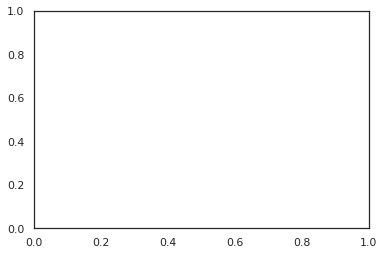

In [159]:
ax = plt.gca()

E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)


plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 35,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,50)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

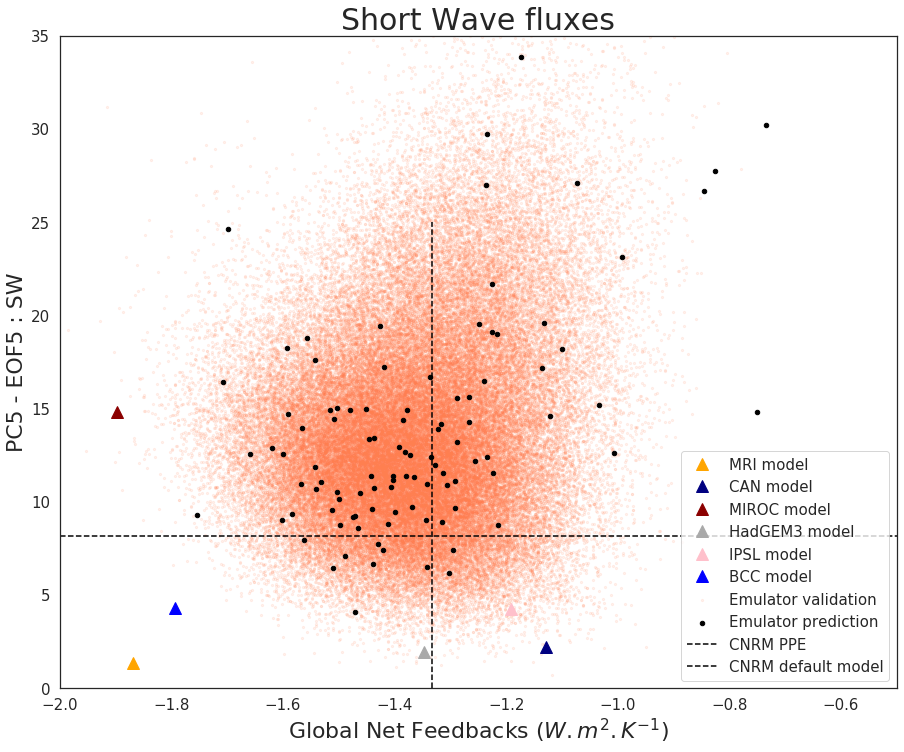

In [123]:
ax = plt.gca()

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#E_multilinreg_val_df.plot(kind='scatter', x='Fdbck_val', y='E_multilinreg_val', color='red', alpha=1, figsize=(15, 12), 
#                     marker='x', ax = ax)
E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='coral', alpha=0.1, figsize=(15, 12), marker='.', ax = ax)


E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'Emulator validation', 'Emulator prediction', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,35)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_pred.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [124]:
fluxes_biases = E_PPE_df
fluxes_biases['E_multilinreg_val'] = E_multilinreg_val_df['E_multilinreg_val']
fluxes_biases['OSE_multilinreg'] = abs(fluxes_biases['E_PPE'] - fluxes_biases['E_multilinreg_val'])
fluxes_biases

,E_PPE,Fdbck,E_multilinreg_val,OSE_multilinreg
0,27.756642,-0.825236,11.653032,16.103610
1,12.577989,-1.659636,12.632127,0.054139
2,8.773974,-1.215000,10.008092,1.234118
3,13.905584,-1.321641,11.173664,2.731920
4,14.813880,-0.750397,3.321480,11.492401
...,...,...,...,...
97,14.947696,-1.516367,10.883330,4.064367
98,9.332918,-1.584491,10.203669,0.870752
99,9.195344,-1.474525,10.416885,1.221541
100,13.354620,-1.445422,10.606888,2.747732


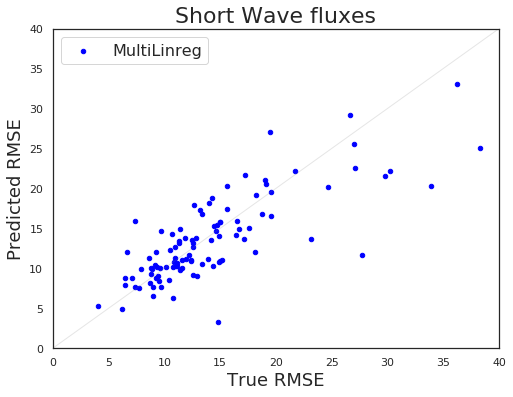

In [125]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title= TITLE 
fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
#fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_lasso_val', color='blue', alpha=0.6, 
#                     marker="o", ax = ax)

plt.xlabel('True RMSE', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted RMSE', fontsize = 18)#, fontsize=18)
plt.legend(['MultiLinreg', 'LASSO'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0,40)
plt.xlim(0,40)
ax.plot((0, 40), (0, 40), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### Save data 

In [126]:
OSE = fluxes_biases['OSE_multilinreg'].mean()
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+variable+'.npy', OSE)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy', E_p1)

In [127]:
OSE

2.7603726248947056

In [128]:
RMSE_val = fluxes_biases['E_multilinreg_val']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_val_'+variable+'.npy', RMSE_val)

In [129]:
## SAVE 
E_multilinreg_pred = E_multilinreg_pred_df['E_multilinreg_pred'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable+'.npy', E_multilinreg_pred)

E_PPE = E_PPE_df['E_PPE'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy', E_PPE)

In [130]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy', E_p1)

### [Back to the top](#top)

# <a id="histograms">Figure histograms</a> </li>

In [131]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
p1_feedback = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")

In [132]:
E_MLR = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable+'.npy')
Fdbck_MLR = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
MLR_df=pd.DataFrame(E_MLR, columns=['E_MLR'])
MLR_df['Fdbck'] = Fdbck_MLR
MLR_df

,E_MLR,Fdbck
0,4.312227,-1.499698
1,11.596800,-1.339351
2,13.563705,-1.323732
3,9.675836,-1.541909
4,9.771319,-1.346961
...,...,...
99995,14.598154,-1.453679
99996,16.115265,-1.410350
99997,12.940145,-1.296397
99998,15.087888,-1.299809


In [133]:
E_MLR_short = []
tmp = []
Fdbck_MLR_short = []
cpt=0

for i in MLR_df['E_MLR']:
    if i <= E_p1:
        E_MLR_short.append(i)
        toto = MLR_df['Fdbck'][cpt]
        Fdbck_MLR_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

MLR_short = pd.DataFrame()
MLR_short['Fdbck'] = Fdbck_MLR_short
MLR_short['E_MLR'] = E_MLR_short
MLR_short

,Fdbck,E_MLR
0,-1.499698,4.312227
1,-1.253085,6.854687
2,-1.377945,5.510192
3,-1.126052,6.564878
4,-1.243893,6.174224
...,...,...
12248,-1.432413,7.058199
12249,-1.233090,7.116928
12250,-1.430482,6.362477
12251,-1.319160,7.532424


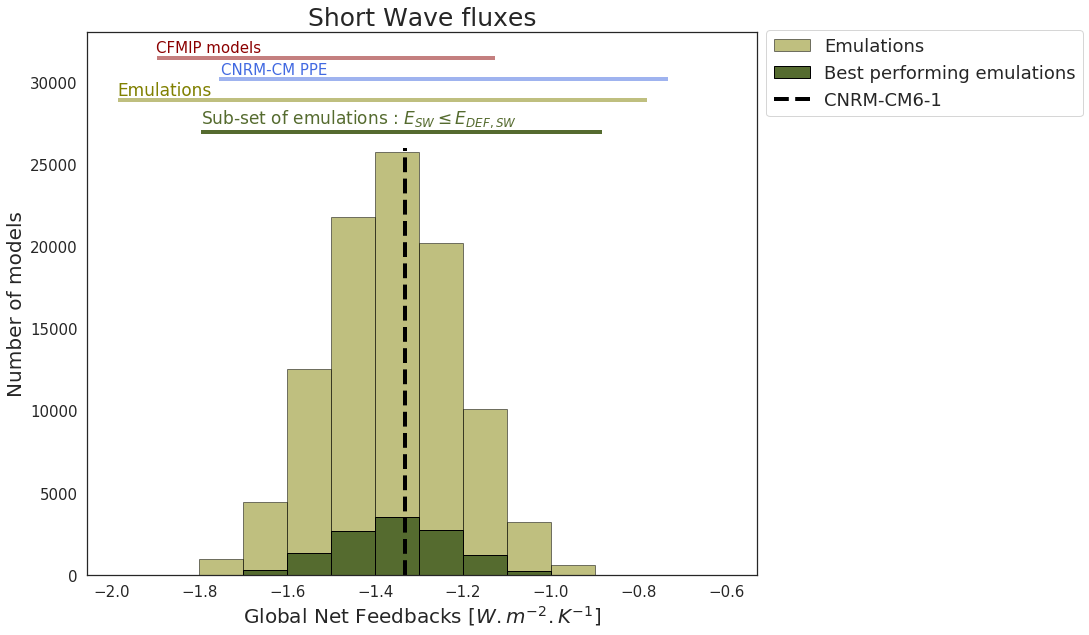

In [134]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_MLR, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'olive', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(MLR_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'darkolivegreen', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 26000,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(31500.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 31800.0, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(30200.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 30500.0, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(27000.0,xmin = MLR_short['Fdbck'].min(),xmax = MLR_short['Fdbck'].max(),
           colors='darkolivegreen', linewidth=4.0, linestyles='solid')
plt.text(MLR_short['Fdbck'].min(), 27500.0, 'Sub-set of emulations : $E_{SW}\leq E_{DEF,SW}$', 
         color = 'darkolivegreen', fontsize=17)

legend=['Emulations', 'Best performing emulations', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [135]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
#PPE_df

In [136]:
E_PPE_short = []
tmp = []
Fdbck_PPE_short = []
cpt=0

for i in PPE_df['E_PPE']:
    if i <= E_p1:
        E_PPE_short.append(i)
        toto = PPE_df['Fdbck'][cpt]
        Fdbck_PPE_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

PPE_short = pd.DataFrame()
PPE_short['Fdbck'] = Fdbck_PPE_short
PPE_short['E_PPE'] = E_PPE_short
#PPE_short

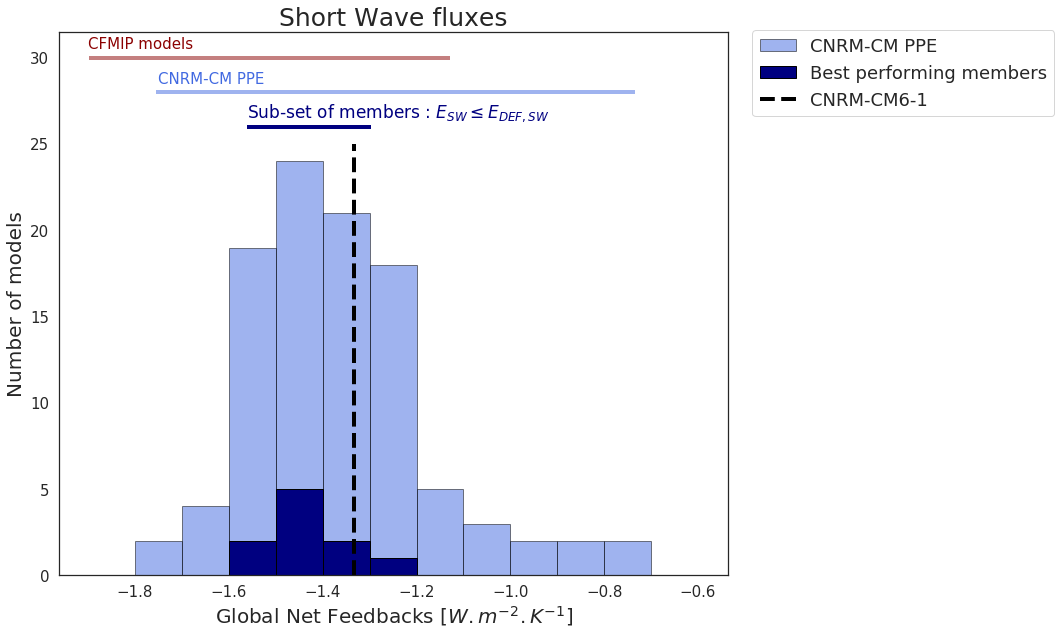

In [137]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_PPE, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'royalblue', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(PPE_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'navy', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 25,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(30.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 30.5, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(28.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 28.5, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

#plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
#           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
#plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(26.0,xmin = PPE_short['Fdbck'].min(),xmax = PPE_short['Fdbck'].max(),
           colors='navy', linewidth=4.0, linestyles='solid')
plt.text(PPE_short['Fdbck'].min(), 26.5, 'Sub-set of members : $E_{SW}\leq E_{DEF,SW}$', 
         color = 'navy', fontsize=17)

legend=['CNRM-CM PPE', 'Best performing members', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="optim">Step 5 - Optimisation</a> </li>

The objective here is to optimize the emulators described above in order to obtain a sub-set of the best parametrizations for each bins of feedback values. In other words, we aim to fine the parametrization which minimizes the error $E_{tot}$ given by the control mean state emulator, while showing a global net feedback value predicted by the feedback emulator within a chosen bin. It is a case of linear minimization with constraint and the optimizer used here comes from the SciPy Python's library and uses sequential least squares programming (SLSQP).

### Functions 

In [143]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

def RMSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

def RMSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_eof_2D, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = RMSE(mod, obs, W_rmse_2D)
    return diff

In [144]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
    y = np.load(file=path_file_npy+"/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save(path_file_npy+'/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save(path_file_npy+'/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [145]:
## --Full function predict PC from x + reconstruct 3D field + compute partial RMSE

def function_RMSE_emulator_std(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D): 

    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    pc = [pc1, pc2, pc3, pc4, pc5]
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims=2)
    
    U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
    pc = U_obs
    nb_dims = 2 
    X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

    E = RMSE_rec(X_rec_mod, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    
    return E

def function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D): 
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable, eofs_combined, 
                                   X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    return float(E)

## --Function feedbacks

def em_fdb_std(x) :

    X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
    y = np.load(file = path_file_npy+"/Net_feedbacks.npy")
    param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred

In [146]:
# -- FONCTION JACOBIAN 

def jacobian(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D) :
    
    ## -- Data
    
    Beta1 = np.load(path_file_npy+'/Beta1.npy')
    Beta2 = np.load(path_file_npy+'/Beta2.npy')
    Beta3 = np.load(path_file_npy+'/Beta3.npy')
    Beta4 = np.load(path_file_npy+'/Beta4.npy')
    Beta5 = np.load(path_file_npy+'/Beta5.npy')
    
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    nb_dims = 2 
    
    ## -- A = RMSE_rec
    A = function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    #print(A)
    ## -- B = Sigma(2*(X_mod - X_rec_obs))
    toto = x - MEAN
    x_std = toto/STD
    
    pc1 = MultiLinReg_pred(x_std, 1, variable)
    pc2 = MultiLinReg_pred(x_std, 2, variable)
    pc3 = MultiLinReg_pred(x_std, 3, variable)
    pc4 = MultiLinReg_pred(x_std, 4, variable)
    pc5 = MultiLinReg_pred(x_std, 5, variable)
    
    pc = [pc1, pc2, pc3, pc4, pc5]
    X_mod = reconstruct_X(eofs_combined, pc, nb_dims)
    
    add =  X_mod - X_rec_obs
    tmp = 2*eofs_combined*add
    B = tmp.sum(['lat', 'lon'])
    
    ## C = Beta*eofs_combined
    pc_beta = []
    for i in range(0, len(Beta1), 1) :
        tmp = ([Beta1[i], Beta2[i], Beta3[i], Beta4[i], Beta5[i]])
        pc_beta.append(tmp)
    C = xr.DataArray(pc_beta, dims = ['param', 'eofs'])
    
    ## -- jac = 1/(2*A) * B * C
    tmp1 = 1/(2*float(A)) 
    tmp2 = np.dot(C, B)
    jac = np.dot(tmp1, tmp2)
    
    return jac

In [147]:
## --Functions constraints on the feedbacks

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


## --Functions optimization

def Optimization(x_best, ind, xlim, variable, eofs_combined, X_rec_obs, 
                 Mean, W_eof_2D, W_rmse_2D) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
   
        fdb_low = em_fdb(x0)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0)
        #print('fdb_x0 = '+str(fdb_x0))
        fun_x0 = function_RMSE_emulator(x0, variable, eofs_combined, X_rec_obs, 
                                        Mean, W_eof_2D, W_rmse_2D)
        print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
    
        sol = minimize(function_RMSE_emulator,  x0, 
                       args=(variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D), 
                       method='SLSQP', jac = jacobian,
                       bounds=xlim, constraints=(cons1, cons2),
                       options={'disp': True, 'ftol' : 0.001, 'maxiter' : 100})    
                        # , 'maxiter' : 250   jac = jacobian, , tol = 0.001
                        # constraints=(cons1, cons2),
    

        tmp_fun = function_RMSE_emulator(sol.x, variable, eofs_combined, X_rec_obs, 
                                         Mean, W_eof_2D, W_rmse_2D)
        tmp_fdbck = em_fdb(sol.x)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_x.append(sol.x)
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [148]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

### Get the data

In [149]:
E_p1 = np.load(path_file_npy+'/E_p1_'+variable+'.npy')
p1_feedbacks = np.load(path_file_npy+'/Net_feedbacks_p1.npy')

In [150]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')

E_PPE_df = pd.DataFrame()
E_PPE_df['Fdbck'] = Fdbck_PPE
E_PPE_df['RMSE'] = E_PPE
E_PPE_df

,Fdbck,RMSE
0,-0.825236,27.756642
1,-1.659636,12.577989
2,-1.215000,8.773974
3,-1.321641,13.905584
4,-0.750397,14.813880
...,...,...
97,-1.516367,14.947696
98,-1.584491,9.332918
99,-1.474525,9.195344
100,-1.445422,13.354620


In [151]:
E_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_"+variable+".npy")
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")


E_multilinreg_pred_df = pd.DataFrame(E_multilinreg_pred)
E_multilinreg_pred_df['E_multilinreg_pred'] = E_multilinreg_pred
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred[0:100000]
E_multilinreg_pred_df = E_multilinreg_pred_df.drop([0], axis=1)
E_multilinreg_pred_df

,E_multilinreg_pred,Fdbck_pred
0,4.312227,-1.499698
1,11.596800,-1.339351
2,13.563705,-1.323732
3,9.675836,-1.541909
4,9.771319,-1.346961
...,...,...
99995,14.598154,-1.453679
99996,16.115265,-1.410350
99997,12.940145,-1.296397
99998,15.087888,-1.299809


### Initial guess for Optimization 1

In [152]:
E_multilinreg_pred_df['Fdbck_pred_round'] = E_multilinreg_pred_df['Fdbck_pred'].round(decimals=2)
E_multilinreg_pred_df = E_multilinreg_pred_df.set_index('Fdbck_pred_round')
E_multilinreg_pred_df['members'] = range(0,100000,1) 
#E_multilinreg_pred_df        

In [153]:
new_df=pd.DataFrame()
new_df['E_multilinreg_pred_best'] = E_multilinreg_pred_df['E_multilinreg_pred'].groupby('Fdbck_pred_round').min()
new_df = new_df.reset_index()
#new_df

In [154]:
list_RMSE = new_df['E_multilinreg_pred_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_multilinreg_pred_df['E_multilinreg_pred'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_multilinreg_pred_df['Fdbck_pred'].iloc[cpt])
            tmp_member.append(E_multilinreg_pred_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck_pred'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
#new_df

### Optimization 1 

In [155]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [156]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
#xlim

In [157]:
sol_df = Optimization(x_best, 0.0001, xlim, variable, eofs_combined, X_rec_obs, 
                      Mean, W_eof_2D, W_rmse_2D)
#sol_df

fun_x0 = 19.203807320048163
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 19.203807320048163
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 12.717755821590792
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.69866870730718
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 2
fun_x0 = 19.702614668172448
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 19.48008401989223
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 6
fun_x0 = 31.15779387510097
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 30.873941657323027
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 7
fun_x0 = 12.155966613639288
Optimization terminated su

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.7314112285110554
            Iterations: 12
            Function evaluations: 78
            Gradient evaluations: 8
fun_x0 = 4.394777617369774
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.648456207806599
            Iterations: 15
            Function evaluations: 103
            Gradient evaluations: 11
fun_x0 = 2.675555814282879
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.48186759457315
            Iterations: 22
            Function evaluations: 188
            Gradient evaluations: 18
fun_x0 = 2.984420868266651
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.984420868266651
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 3.8051198908628536
Optimization terminated successfully.    (Exit mode 0

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4399439059236914
            Iterations: 4
            Function evaluations: 45
            Gradient evaluations: 4
fun_x0 = 1.8730045748939133
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1.6006662732179138
            Iterations: 25
            Function evaluations: 221
            Gradient evaluations: 21
fun_x0 = 1.7387659082139875
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7387659082139875
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 2.201166772023923
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.1082129074874203
            Iterations: 12
            Function evaluations: 78
            Gradient evaluations: 8
fun_x0 = 1.9204292226513713
Optimization terminated successfully.    (Exit mode 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.547584228944366
            Iterations: 17
            Function evaluations: 133
            Gradient evaluations: 13
fun_x0 = 7.82764876391787
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.735977897631818
            Iterations: 14
            Function evaluations: 100
            Gradient evaluations: 10
fun_x0 = 14.688972670858028
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 14.586976502233915
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 9
fun_x0 = 16.080086929215206
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 15.834611807610436
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 9
fun_x0 = 22.273646738218925
Optimization terminated successfully.    (Exit 

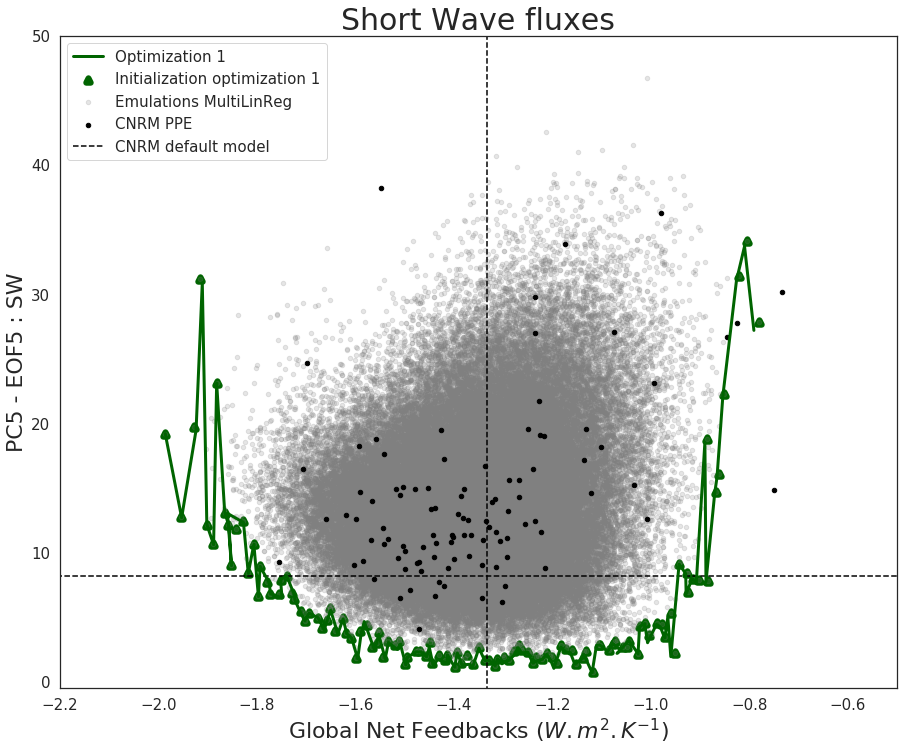

In [161]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 50,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,50)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Initial guess for Optimization 2 (param. moothing)

In [162]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

,Fdbck,x1_smth_1,x2_smth_1,x3_smth_1,x4_smth_1,x5_smth_1,x6_smth_1,x7_smth_1,x8_smth_1,x9_smth_1,...,x21_smth_150,x22_smth_150,x23_smth_150,x24_smth_150,x25_smth_150,x26_smth_150,x27_smth_150,x28_smth_150,x29_smth_150,x30_smth_150
0,-1.985956,0.101203,0.935243,2.308255,29.837952,-0.079684,8.934402,3.064550,0.005121,0.000707,...,-2.509369,-25.309508,0.074965,14.089321,0.000044,0.911282,0.653074,0.507018,0.534708,6.132903
1,-1.952587,0.105707,0.663333,2.258199,23.665665,-0.081851,8.167133,4.073240,0.006647,0.000753,...,-2.565599,-26.089405,0.076384,14.044782,0.000044,0.902660,0.667575,0.519706,0.542060,6.004732
2,-1.923254,0.088214,0.681698,1.869930,22.906084,-0.170325,8.365347,2.489147,0.006144,0.000652,...,-2.622021,-26.858058,0.077780,13.999202,0.000044,0.894221,0.681862,0.532284,0.549348,5.878966
3,-1.910639,0.090704,0.779547,2.091524,21.159494,-0.336299,9.218157,0.876474,0.004637,0.000532,...,-2.678777,-27.604762,0.079132,13.951584,0.000044,0.886139,0.695731,0.544648,0.556511,5.757914
4,-1.901409,0.093176,0.856266,1.875030,19.033224,-0.324889,9.781400,2.591418,0.003317,0.000728,...,-2.735922,-28.319853,0.080422,13.901011,0.000044,0.878566,0.708997,0.556704,0.563493,5.643695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.865196,0.232231,2.536484,1.613379,8.856301,-0.409028,2.529527,5.758584,0.005927,0.000346,...,-2.632301,-45.184853,0.018897,7.023913,0.000050,0.587197,0.606948,0.867305,0.862625,6.709767
109,-0.853327,0.220449,2.604907,1.234719,10.937932,-0.392259,1.489260,5.317074,0.003945,0.000548,...,-2.599926,-45.663274,0.018789,7.581952,0.000048,0.573689,0.594030,0.892788,0.877382,6.953674
110,-0.825666,0.235225,2.611534,1.036282,16.660276,-0.366538,0.642643,4.673808,0.003460,0.000663,...,-2.566617,-46.157514,0.018698,8.159476,0.000046,0.559642,0.580803,0.919331,0.892460,7.207327
111,-0.809321,0.259085,2.596757,1.305945,22.222738,-0.313317,0.748602,4.652168,0.005753,0.000707,...,-2.532682,-46.662936,0.018617,8.750371,0.000044,0.545225,0.567362,0.946596,0.907754,7.467654


In [ ]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Optimization 2

In [163]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.10120333, 0.93524323, 2.30825521, ..., 0.50701769, 0.53470794,
        6.13290286],
       [0.10250558, 0.94212885, 2.27155835, ..., 0.51970555, 0.54206014,
        6.00473161],
       [0.10383383, 0.94883467, 2.23502561, ..., 0.53228363, 0.54934806,
        5.87896572],
       ...,
       [0.26061531, 2.61189471, 1.15922301, ..., 0.91933148, 0.89246001,
        7.20732674],
       [0.26791562, 2.66662688, 1.15703268, ..., 0.94659623, 0.9077545 ,
        7.46765423],
       [0.27525926, 2.72175464, 1.15461987, ..., 0.97422549, 0.92315751,
        7.73137428]])

In [165]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_emulator(i, variable, eofs_combined, 
                                 X_rec_obs, Mean, W_eof_2D,W_rmse_2D)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

,Fdbck,RMSE
0,-1.985956,19.203807
1,-1.952587,18.235900
2,-1.923254,17.282472
3,-1.910639,16.348894
4,-1.901409,15.440142
...,...,...
108,-0.865196,20.086784
109,-0.853327,21.817755
110,-0.825666,23.586877
111,-0.809321,25.382308


In [166]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variable, eofs_combined, 
                                 X_rec_obs, Mean, W_eof_2D,W_rmse_2D)
#sol_df_2

fun_x0 = 19.203807320048163
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 19.203807320048163
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 18.23590013991785
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.219802715124114
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 3
fun_x0 = 17.282472150178236
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.282472150178236
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 16.34889429324433
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 16.34889429324433
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 15.44014213715346
Optimization terminated success

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.527245095186053
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 2.37413518471572
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.3526526712365854
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 7
fun_x0 = 2.2281755923064757
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.200652791101295
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 6
fun_x0 = 2.0890307962541756
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.0890307962541756
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
fun_x0 = 1.9563828392149694
Optimization terminated successfully.    (Exit mode 0)
 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5538811163769337
            Iterations: 6
            Function evaluations: 67
            Gradient evaluations: 6
fun_x0 = 0.6064613608922959
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5805029291296578
            Iterations: 10
            Function evaluations: 100
            Gradient evaluations: 9
fun_x0 = 0.6336265235260072
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6373004168934585
            Iterations: 9
            Function evaluations: 78
            Gradient evaluations: 7
fun_x0 = 0.6664044432825028
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6650329121866209
            Iterations: 5
            Function evaluations: 45
            Gradient evaluations: 4
fun_x0 = 0.7048282038950465
Optimization terminated successfully.    (Exit mod

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 15.046642321479155
            Iterations: 15
            Function evaluations: 111
            Gradient evaluations: 11
fun_x0 = 16.783429764073357
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 16.611147440400067
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 9
fun_x0 = 18.405196172883166
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.206584979013833
            Iterations: 15
            Function evaluations: 111
            Gradient evaluations: 11
fun_x0 = 20.086783983319236
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 19.826733123304713
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 9
fun_x0 = 21.81775544166022
Optimization terminated successfully.    (Exi

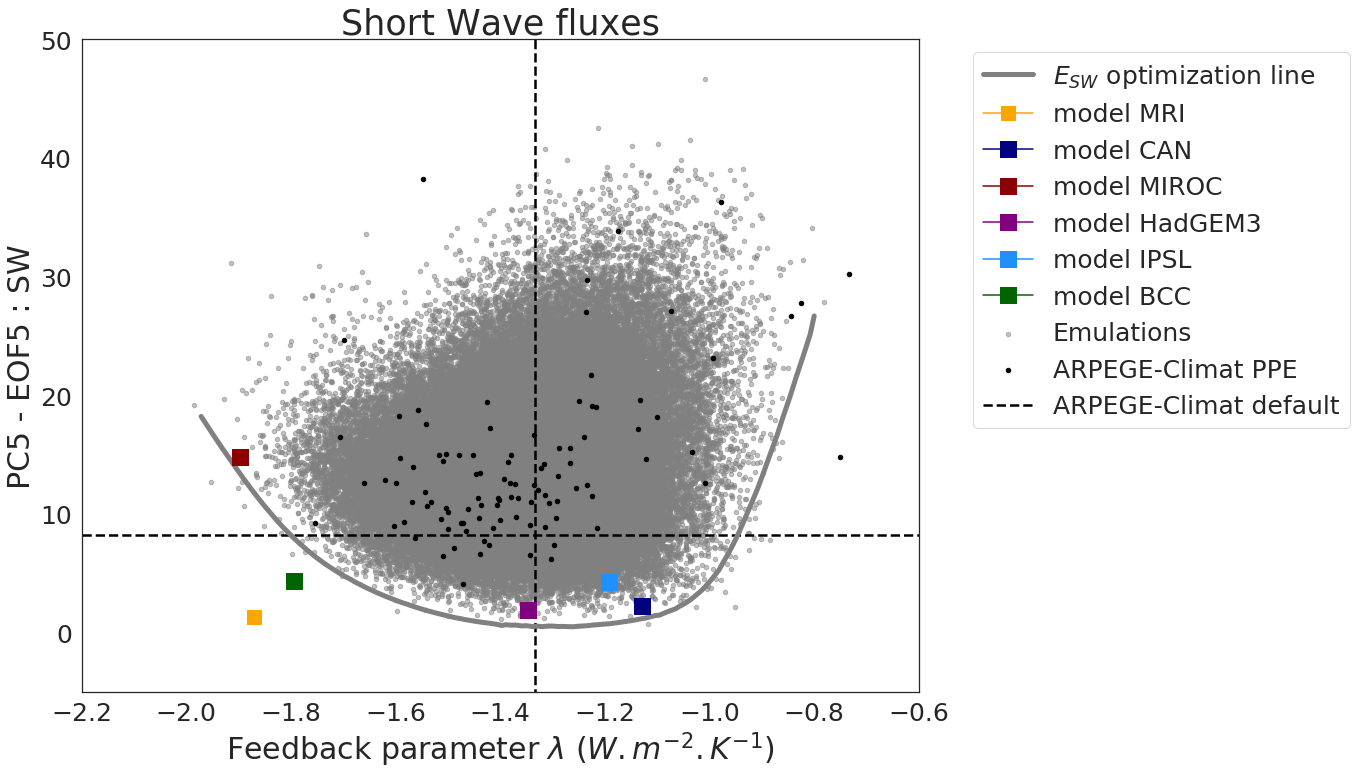

In [168]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.5, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), alpha=1.0,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 50,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


legend = ['$E_{SW}$ optimization line', 'model MRI','model CAN','model MIROC','model HadGEM3','model IPSL', 'model BCC', 
          'Emulations','ARPEGE-Climat PPE', 'ARPEGE-Climat default']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.legend(legend, fontsize=25, bbox_to_anchor=(1.05, 1))

plt.title(TITLE, fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylim(-5,50)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save data

In [169]:
RMSE_optim2 = sol_df_2['sol_fun']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable+'.npy', Fdbck_optim2)

### [Back to the top](#top)

# <a id="selection">Step 6 - Optimal subset of parameters</a> </li>

## Projection of sub-set on EOF basis

### Settings 

In [5]:
ENSEMBLE = 'ENSEMBLE4_selection/'
path_PPE_short = '/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
product = 'CERES'

In [6]:
nb_p_select = ['p860', 'p861', 'p862', 'p864', 'p865', 'p866', 'p867', 'p868', 'p869', 
                    'p870', 'p871', 'p872', 'p873','p874', 'p875', 'p876', 'p877', 'p878', 'p879',
                    'p880', 'p881', 'p882', 'p883']
len(nb_p_select)

23

In [7]:
N_error = 128*256

### Functions

In [8]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

def RMSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

def RMSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_eof_2D, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = RMSE(mod, obs, W_rmse_2D)
    return diff

In [9]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
    y = np.load(file=path_file_npy+"/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save(path_file_npy+'/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save(path_file_npy+'/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [10]:
## --Full function predict PC from x + reconstruct 3D field + compute partial RMSE

def function_RMSE_emulator_std(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D): 

    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    pc = [pc1, pc2, pc3, pc4, pc5]
    X_rec_mod = reconstruct_X(eofs_combined, pc, nb_dims=2)
    
    U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
    pc = U_obs
    nb_dims = 2 
    X_rec_obs = reconstruct_X(eofs_combined, pc, nb_dims)

    E = RMSE_rec(X_rec_mod, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    
    return E

def function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D): 
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable, eofs_combined, 
                                   X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    return float(E)

### EOF, tas_mean and PCs

In [11]:
# --Mean
Mean =  pd.read_pickle(path_file_npy+'/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})

# --Weights
W_eof_3D = np.load(path_file_npy+'/W_eof_3D_'+variable+'.npy')
W_eof_2D = np.load(path_file_npy+'/W_eof_2D_'+variable+'.npy')
W_rmse_2D = np.load(path_file_npy+'/W_rmse_2D_'+variable+'.npy')

In [12]:
# -- eof_combined 
eofs=[]
for i in range(1,6,1) :
    eof_tmp = pd.read_pickle(path_file_npy+'/PPE2_EOFmap'+str(i)+'_'+variable+'.npy').to_xarray().to_array()
    eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
    eofs.append(eof_tmp)
                     
## --Combine the 5 modes for reconstruction
eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')

## Error estimate in ARPEGE-Climat

In [13]:
E_p1 = np.load(path_file_npy+'/E_p1_'+variable+'.npy')
p1_feedbacks = np.load(path_file_npy+'/Net_feedbacks_p1.npy')

In [14]:
# -- X_rec_obs 
U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
X_rec_obs = reconstruct_X(eofs_combined, pc=U_obs, nb_dims=2) 

In [15]:
E_df_selection=[]
for i in nb_p_select :
    U_mod = np.load(path_file_npy+'/U_'+i+'_'+variable+'.npy')
    X_rec_mod = reconstruct_X(eofs_combined, pc=U_mod, nb_dims=2)
    E = RMSE_rec(X_rec_mod, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)

    E_df_selection.append(float(E))

#E_df_selection

In [16]:
Fdbck_selection = np.load('/data/home/globc/peatier/CNRMppe/PPE/'+ENSEMBLE+'files/npy/SIX_Net_feedbacks.npy')
Fdbck_selection

array([-1.70182872, -1.64660211, -1.65067859, -1.57314086, -1.60480499,
       -1.59460457, -1.584928  , -1.5537655 , -1.48534687, -1.53561556,
       -1.46918408, -1.40725935, -1.30876013, -1.17850196, -1.11752943,
       -1.07712932, -0.9657925 , -0.9024847 , -0.70984636, -0.59886702,
       -0.64100514, -0.69628074, -0.67599579])

## Error estimate with emulator

In [19]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select2.npy')
df_select = pd.DataFrame(file).drop([2])
df_select

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.978650,-1.985892,0.101214,0.935368,2.308099,29.837961,-0.079678,8.933529,3.065236,0.005121,...,-2.509224,-25.309487,0.074965,14.089843,0.000044,0.911284,0.653104,0.507047,0.534738,6.132308
1,1.762048,-1.915792,0.105226,0.946306,2.217400,23.271347,-0.119617,8.326439,3.862775,0.004866,...,-2.699887,-28.735554,0.081387,13.630740,0.000048,0.877644,0.714951,0.584855,0.575630,5.421690
3,1.365314,-1.793117,0.117653,0.925779,1.993968,16.535588,-0.144756,6.979020,4.723136,0.004277,...,-2.879095,-32.476790,0.084603,12.153954,0.000052,0.867025,0.789303,0.687230,0.631255,4.689734
4,1.210276,-1.739799,0.124279,0.914087,1.872786,16.160868,-0.139411,6.202231,4.822008,0.004093,...,-2.861966,-33.377190,0.081028,10.923123,0.000054,0.872076,0.799245,0.704418,0.642916,4.478891
5,1.092965,-1.688818,0.129353,0.916731,1.799238,16.227429,-0.133492,5.376256,4.795431,0.004196,...,-2.800839,-33.904028,0.076146,9.493748,0.000055,0.867365,0.798937,0.710677,0.646475,4.211288
6,1.002655,-1.638441,0.132807,0.937947,1.799551,16.191064,-0.127751,4.593259,4.620000,0.004596,...,-2.694675,-33.900412,0.071569,8.145789,0.000057,0.854647,0.792044,0.718739,0.648308,3.984981
7,0.931638,-1.588352,0.135540,0.988634,1.843533,16.185412,-0.119959,3.950301,4.326672,0.005104,...,-2.559700,-33.503864,0.067906,7.006633,0.000058,0.840374,0.777997,0.731503,0.656286,3.897473
8,0.873728,-1.538515,0.139184,1.073116,1.875451,16.454288,-0.109988,3.473790,4.068607,0.005482,...,-2.448508,-33.084557,0.064489,6.016906,0.000057,0.829561,0.758095,0.742957,0.673381,3.920094
9,0.824222,-1.488119,0.143873,1.170296,1.863909,16.803264,-0.101644,3.133087,3.975235,0.005613,...,-2.393045,-32.867850,0.060039,5.179393,0.000056,0.824722,0.736912,0.749706,0.694522,4.013213
10,0.782407,-1.438072,0.148822,1.243236,1.816102,16.938484,-0.101276,2.907720,4.027534,0.005509,...,-2.373002,-32.887497,0.053725,4.569307,0.000055,0.827338,0.718612,0.754621,0.711067,4.198545


In [20]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_total.npy')
df_optim_total = pd.DataFrame(file)
df_optim_total

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.978650,-1.985892,0.101214,0.935368,2.308099,29.837961,-0.079678,8.933529,3.065236,0.005121,...,-2.509224,-25.309487,0.074965,14.089843,0.000044,0.911284,0.653104,0.507047,0.534738,6.132308
1,1.934300,-1.971665,0.101923,0.938328,2.290108,28.452721,-0.088391,8.812695,3.234051,0.005073,...,-2.549339,-26.039369,0.076355,14.002736,0.000045,0.903765,0.666056,0.523087,0.543147,5.980319
2,1.890688,-1.957551,0.102680,0.940761,2.272516,27.085657,-0.096932,8.693807,3.398839,0.005022,...,-2.589319,-26.757640,0.077713,13.913016,0.000046,0.896417,0.678766,0.539040,0.551536,5.832291
3,1.847656,-1.943524,0.103436,0.942923,2.254566,25.755345,-0.105087,8.573051,3.560103,0.004973,...,-2.628029,-27.452732,0.079016,13.821948,0.000047,0.889531,0.691275,0.554654,0.559706,5.688266
4,1.804734,-1.929515,0.104246,0.945437,2.235712,24.480462,-0.112664,8.448105,3.717275,0.004923,...,-2.664538,-28.113783,0.080253,13.730112,0.000047,0.883268,0.703476,0.569898,0.567690,5.549150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.677538,-0.835138,0.251033,2.497033,1.288496,23.511310,-0.392016,1.782295,5.319526,0.007066,...,-2.574742,-45.057061,0.018243,7.164023,0.000046,0.571366,0.599374,0.892900,0.885384,6.626445
109,1.778052,-0.822073,0.257232,2.554557,1.254177,24.881865,-0.402303,1.785273,5.539171,0.007239,...,-2.559205,-45.596600,0.018223,7.704046,0.000045,0.560593,0.587080,0.913689,0.894995,6.904529
110,1.884405,-0.808612,0.263653,2.615155,1.219543,26.338284,-0.412717,1.791978,5.772441,0.007417,...,-2.544069,-46.176296,0.018176,8.270878,0.000044,0.549477,0.574530,0.935129,0.905142,7.200580
111,1.972740,-0.797967,0.269891,2.650933,1.176321,27.507121,-0.420415,1.778796,5.940043,0.007548,...,-2.509903,-46.511473,0.018145,8.830086,0.000044,0.540922,0.561021,0.957529,0.910594,7.433596


In [21]:
E_emulator_selection = []
for i in range(0,len(df_select),1) :
    x = df_select.iloc[i][2:]
    E = function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    E_emulator_selection.append(E)

E_emulator_selection

[19.200058364157364,
 16.08223067438066,
 11.580526416449784,
 9.969171183680029,
 8.60509052277588,
 7.437505017432072,
 6.464243439539872,
 5.662342674769732,
 4.937331969205491,
 4.30100148834537,
 3.8577062885060838,
 3.625831112392682,
 3.474209218346136,
 3.2136781806242385,
 2.8340914363964558,
 2.5605064604468337,
 2.7169365868481794,
 3.68782156926381,
 5.958472440104366,
 10.045221323306938,
 16.311102454371156,
 24.26930633721988,
 27.461740425304]

In [22]:
E_optim_total = []
for i in range(0,len(df_optim_total),1) :
    x = df_optim_total.iloc[i][2:]
    E = function_RMSE_emulator(x, variable, eofs_combined, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    E_optim_total.append(E)
    
#E_optim_total

In [23]:
RMSE_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable+'.npy')
Fdbck_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable+'.npy')
sol_df_2=pd.DataFrame(RMSE_optim_line)
sol_df_2['sol_fun'] = sol_df_2[0]
sol_df_2['Fdbck'] = Fdbck_optim_line
sol_df_2

,0,sol_fun,Fdbck
0,19.203807,19.203807,-1.985956
1,18.219803,18.219803,-1.971433
2,17.282472,17.282472,-1.957609
3,16.348894,16.348894,-1.943564
4,15.440142,15.440142,-1.929669
...,...,...,...
108,19.826733,19.826733,-0.846192
109,21.582744,21.582744,-0.833600
110,23.365891,23.365891,-0.820102
111,25.152756,25.152756,-0.807140


In [24]:
df_optim_total_final= pd.DataFrame(E_optim_total, columns=['RMSE'])
df_optim_total_final['Fdbck']= df_optim_total[1]
df_optim_total_final

,RMSE,Fdbck
0,19.200058,-1.985892
1,18.537679,-1.971665
2,17.894810,-1.957551
3,17.272991,-1.943524
4,16.664532,-1.929515
...,...,...
108,20.957922,-0.835138
109,22.580808,-0.822073
110,24.269306,-0.808612
111,25.702677,-0.797967


In [25]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
PPE_df

,E_PPE,Fdbck
0,27.756642,-0.825236
1,12.577989,-1.659636
2,8.773974,-1.215000
3,13.905584,-1.321641
4,14.813880,-0.750397
...,...,...
97,14.947696,-1.516367
98,9.332918,-1.584491
99,9.195344,-1.474525
100,13.354620,-1.445422


## Plot

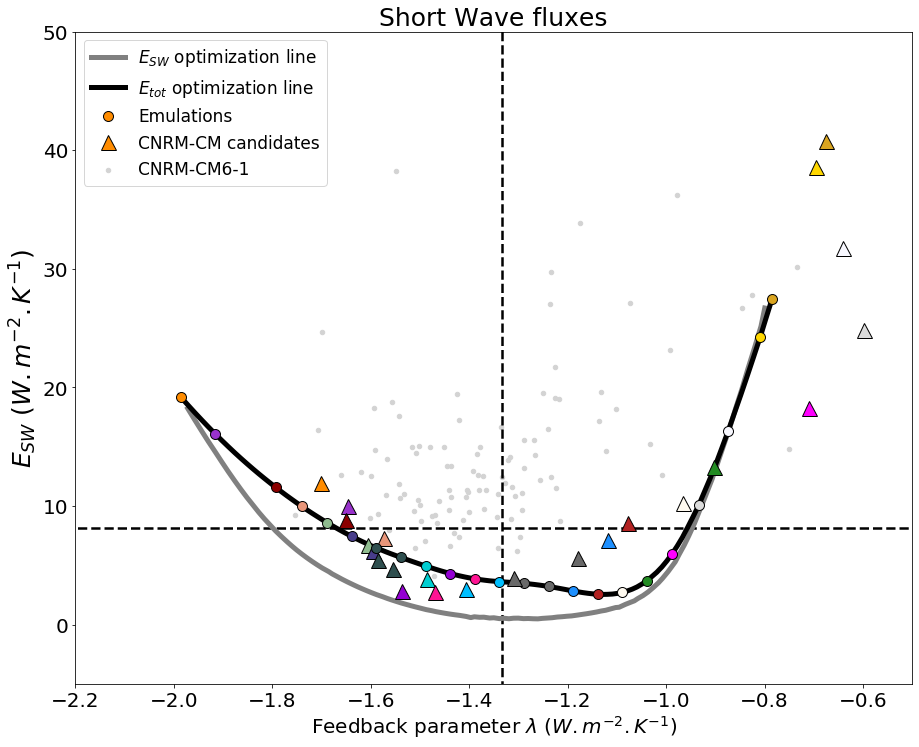

In [26]:
import matplotlib.colors as mcolors
import random

plt_colors = list(mcolors.CSS4_COLORS.keys())
st=30
colors=plt_colors[st:st+23]

cpt=0

ax = plt.gca()

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, 
                  linewidth=5, figsize=(15, 12), ax = ax)

df_optim_total_final.plot(kind='line', x='Fdbck', y='RMSE', color='black', alpha=1, 
                          linewidth=5, ax=ax)

PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='lightgray', 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 60.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5, zorder=1)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 80,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

for i in colors :
    if cpt == 0 :
        ax.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], 
                 markerfacecolor=i, color='black', 
                 marker='o', linewidth=0, markersize=10, zorder=8)

        ax.plot(Fdbck_selection[cpt], E_df_selection[cpt], 
                markerfacecolor=i, color='black', 
                marker='^', 
                linewidth=0, markersize=15, zorder=9)
        cpt+=1
    else :
        ax.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], 
                 markerfacecolor=i, color='black',  
                 marker='o', linewidth=0, markersize=10, label='_nolegend_')

        ax.plot(Fdbck_selection[cpt], E_df_selection[cpt], 
                 markerfacecolor=i, color='black',  
                 marker='^', linewidth=0, markersize=15, label='_nolegend_')
        cpt+=1

legend = ['$E_{SW}$ optimization line','$E_{tot}$ optimization line','Emulations','CNRM-CM candidates', 
          'CNRM-CM6-1']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=20)
plt.ylabel(ylabel, fontsize=25)
plt.legend(legend, fontsize=17) #bbox_to_anchor=(1.05, 1)

plt.title(TITLE, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(-5,50)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_selection.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save the data

In [27]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/E_selection_'+variable+'.npy', E_df_selection)

### [Back to the top](#top)

# <a id="correl">Check correlation with simple RMSE</a> </li> 

## Get the data 

In [42]:
# PPE amip simulations 
filename='*_amip_*.nc'


amip={}

for nb_p in nb_p_list :
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_SW_xarr(path, filename, variables)
    

In [43]:
nb_p_select = ['p840', 'p841', 'p842', 'p843','p844', 'p845', 'p846', 'p847']

amip_select={}

for nb_p in nb_p_select :
    path=path_PPE+'ENSEMBLE4_selection/CNRM-CM6-1_amip_PPE_ENSEMBLE4_selection/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    tmp = get_3D_SW_xarr(path, filename, variables)
    amip_select[str(nb_p)] = tmp.assign_coords(lat=amip_list[0]['lat'])
    

In [44]:
path_observation = '/data/scratch/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'

def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month

    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs['SW'] =  df_obs['toa_net_all_mon'] + df_obs['toa_lw_all_mon']
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    SW               (lat, lon) float32 51.417324 51.417324 ... 67.64632

In [45]:
# Reference p1
diff = (amip['p1'].values - obs[variable_obs].values)**2
diff_p1 = sqrt(sum(diff)/(128*256))
diff_p1

KeyError: 'p1'

In [45]:
ej = {}
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_list :
    mod = amip[p]*df_W
    observation = obs[variable]*df_W
    diff_tmp = (mod - observation)**2
    diff = sqrt(diff_tmp['W'].sum(['lat', 'lon'])/(128*256))
    #print(diff_tmp)
    ej[p] = diff
    ej_list.append(float(diff))

In [46]:
df_fig = pd.DataFrame(E_PPE, columns=['E_tas'])
df_fig['RMSE'] = ej_list
df_fig

,E_tas,RMSE
0,22.190244,24.387600
1,10.055562,13.697294
2,7.014416,12.086989
3,11.116918,14.332498
4,11.843062,15.922703
...,...,...
97,11.950042,15.020368
98,7.461267,11.492929
99,7.351283,11.707633
100,10.676445,14.317363


In [47]:
r = np.corrcoef(df_fig['E_tas'], df_fig['RMSE'])
r

array([[1.       , 0.9942805],
       [0.9942805, 1.       ]])

In [48]:
ej = {}
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_select :
    mod = amip_select[p]*df_W
    observation = obs[variable]*df_W
    diff_tmp = (mod - observation)**2
    diff = sqrt(diff_tmp['W'].sum(['lat', 'lon'])/(128*256))
    #print(diff_tmp)
    ej[p] = diff
    ej_list.append(float(diff))
    
df_fig_select = pd.DataFrame(E_df_selection, columns=['E_tas'])
df_fig_select['RMSE'] = ej_list
df_fig_select

,E_tas,RMSE
0,9.816419,13.551763
1,7.784530,12.153960
2,5.226360,10.647741
3,3.473584,9.585635
4,1.684739,9.253375
5,5.309423,10.907538
6,9.423108,13.679223
7,21.356449,23.851603


In [49]:
r = np.corrcoef(df_fig_select['E_tas'], df_fig_select['RMSE'])
r

array([[1.        , 0.99044227],
       [0.99044227, 1.        ]])

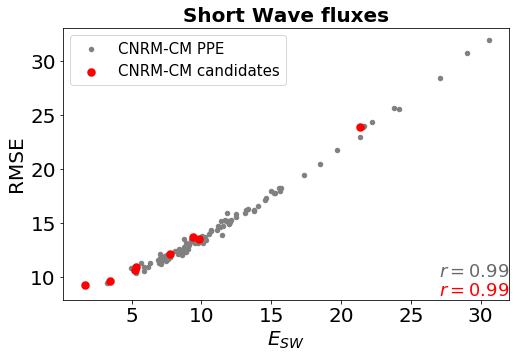

In [57]:
plt.figure(figsize=(8, 5))
    

ax = plt.gca()
#ax2 = ax.twinx()


df_fig.plot(kind='scatter', y='RMSE', x='E_tas', color = 'gray', alpha=1, ax=ax)
df_fig_select.plot(kind='scatter', y='RMSE', x='E_tas', color = 'red', linewidth=4, alpha=1, ax=ax)

#ax.axhline(0, color='k', alpha=0.5)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('$E_{SW}$', size = 20)
ax.set_ylabel('RMSE', size = 20)
ax.set_title('Short Wave fluxes', fontsize=20, 
             fontweight = 'bold')

plt.text(1,0.07,r'$r = 0.99$',horizontalalignment='right',color='dimgray',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.0,r'$r = 0.99$',horizontalalignment='right', color='red',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.plot((0.3, 1.75), (1, 2), linewidth=1.0, color='gray', alpha=0.2)

#plt.xlim([0.0, 2.0])
#plt.ylim([0.0, 2.0])

# Legend .................

legend = [ 'CNRM-CM PPE', 'CNRM-CM candidates']
#ax.get_legend().remove()
ax.legend(legend, fontsize=15) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Correl_RMSE_E_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)